In [1]:
import pandas as pd
import sqlite3
import numpy as np
import ipaddress
import dill

In [2]:
conn = sqlite3.connect('../data/dns.db')

# exclude abuf column, rearrange other ones
# excludes RRSIG records
df = pd.read_sql('''
                  select msm_id, prb_id, timestamp,
                  address_family, resolver_address, local_resolver,
                  target_name, error, rcode, response_type, response_address,
                  rt, ttl
                  from data
                  where response_type != "RRSIG"
                 ''', 
                 con=conn, 
                 parse_dates=['timestamp']
                )

conn.close()

In [3]:
df

,msm_id,prb_id,timestamp,address_family,resolver_address,local_resolver,target_name,error,rcode,response_type,response_address,rt,ttl
0,27186736,10001,2020-09-15 16:50:40,6,fd00::eadf:70ff:fea3:7a26,1,d2dae78b19853165.google.com,,NXDOMAIN,,,20.312,NaN
1,27186736,10001,2020-09-15 16:50:40,4,192.168.178.1,1,df482b60cbd6043e.google.com,,NXDOMAIN,,,15.416,NaN
2,27186736,10006,2020-09-15 16:50:37,4,8.8.8.8,1,fe3c7c017da360ee.google.com,,NXDOMAIN,,,29.835,NaN
3,27186736,10022,2020-09-15 16:50:44,4,10.71.6.12,1,7de23a40f44f4117.google.com,,NXDOMAIN,,,10.700,NaN
4,27186736,10092,2020-09-15 16:50:34,4,2001:4860:4860::8888,1,,"{""socket"": ""connect failed Network is unreacha...",,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13251955,27187241,54984,2020-09-28 16:57:09,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,27.065,NaN
13251956,27187241,55590,2020-09-28 16:57:25,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,36.250,NaN
13251957,27187241,55660,2020-09-28 16:57:21,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,222.830,NaN
13251958,27187241,55692,2020-09-28 16:57:11,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,14.162,NaN


# filter out probes without country information

In [4]:
df = df[~df.prb_id.isin([54205, 54911])]  # manual filter

In [5]:
df.dtypes

msm_id                       int64
prb_id                       int64
timestamp           datetime64[ns]
address_family               int64
resolver_address            object
local_resolver               int64
target_name                 object
error                       object
rcode                       object
response_type               object
response_address            object
rt                         float64
ttl                        float64
dtype: object

In [6]:
conn = sqlite3.connect('../metadata/ripe_probe_metadata.db')
probes = pd.read_sql('select * from metadata', con=conn)
conn.close()
probes['probe_id'] = probes['id']
probes['probe_cc'] = probes['country_code']
probes= probes[['probe_id', 'probe_cc']]
cc = pd.read_csv("../metadata/country_continent.csv", header=0, names=['country', 'continent'], keep_default_na=False)
probes_country = probes.merge(cc, left_on='probe_cc', right_on='country')
probes_country = probes_country[['probe_id', 'country', 'continent']]
probes_country = probes_country.drop_duplicates()

resolvers_dict = {'185.228.168.168':'CleanBrowsing', '1.1.1.1':'Cloudflare', '8.8.8.8':'Google',
                  '208.67.222.123':'OpenDNS', '185.121.177.177':'OpenNIC', '9.9.9.9':'Quad9', '64.6.64.6':'VeriSign',
                  '77.88.8.8':'Yandex', '156.154.70.1':'Neustar UltraRecursive', '45.90.28.0':'NextDNS',
                  '2a0d:2a00:1::1':'CleanBrowsing', '2606:4700:4700::1111':'Cloudflare',
                  '2001:4860:4860::8888':'Google', '2620:0:ccc::2':'OpenDNS',
                  '2a05:dfc7:5::5353':'OpenNIC', '2620:fe::9':'Quad9', '2620:74:1b::1:1':'VeriSign',
                  '2a02:6b8::feed:ff':'Yandex', '2610:a1:1018::1':'Neustar UltraRecursive',
                     '2a07:a8c0::': 'NextDNS'}

resolvers = pd.DataFrame(resolvers_dict.items(), columns=['ip', 'resolver_name'])

In [7]:
probes_country.head()

,probe_id,country,continent
0,10001,NL,EU
1,10015,NL,EU
2,10022,NL,EU
3,10046,NL,EU
4,10101,NL,EU


# =====================================================
# Alternative Resolver IP Addresses

In [12]:
alt_res = pd.read_csv('../metadata/resolvers-extended.csv').drop_duplicates()

In [13]:
'''
45.90.28.0/24
45.90.29.0/24
45.90.30.0/24
2a07:a8c0::/33
2a07:a8c1::/33

'''
def identify_nextdns_ipv6(ip6addr):
    if ipaddress.ip_address(ip6addr) in ipaddress.ip_network('2a07:a8c0::/33') or ipaddress.ip_address(ip6addr) in ipaddress.ip_network('2a07:a8c1::/33'):
        return True
    return False

for nextdns_addr in df[df.resolver_address.str.startswith('2a07:a8c0:') | df.resolver_address.str.startswith('2a07:a8c1:')].resolver_address.unique():
    if identify_nextdns_ipv6(nextdns_addr):
        print(nextdns_addr)
        alt_res = alt_res.append({'ip': nextdns_addr, 'resolver_name':'NextDNS'}, ignore_index=True)
for nextdns_addr in df[df.resolver_address.str.startswith('45.90.28.') | df.resolver_address.str.startswith('45.90.29.') | df.resolver_address.str.startswith('45.90.30.')].resolver_address.unique():
    print(nextdns_addr)
    alt_res = alt_res.append({'ip': nextdns_addr, 'resolver_name':'NextDNS'}, ignore_index=True)

2a07:a8c0::c4:463a
2a07:a8c1::c4:463a
2a07:a8c0::
45.90.28.204
45.90.30.204
45.90.28.56
45.90.30.56
45.90.28.215
45.90.30.215
45.90.28.112
45.90.30.112
45.90.28.0


In [14]:
alt_res

,ip,resolver_name
0,185.228.168.168,CleanBrowsing
1,1.1.1.1,Cloudflare
2,8.8.8.8,Google
3,208.67.222.123,OpenDNS
4,185.121.177.177,OpenNIC
...,...,...
88,45.90.28.215,NextDNS
89,45.90.30.215,NextDNS
90,45.90.28.112,NextDNS
91,45.90.30.112,NextDNS


In [15]:
alt_df = df.merge(alt_res, left_on='resolver_address', right_on='ip', how='left')

In [16]:
alt_df[(alt_df['local_resolver']==1) & ~(alt_df['resolver_name'].isna())]

,msm_id,prb_id,timestamp,address_family,resolver_address,local_resolver,target_name,error,rcode,response_type,response_address,rt,ttl,ip,resolver_name
2,27186736,10006,2020-09-15,4,8.8.8.8,1,fe3c7c017da360ee.google.com,,NXDOMAIN,,,29.835,NaN,8.8.8.8,Google
4,27186736,10092,2020-09-15,4,2001:4860:4860::8888,1,,"{""socket"": ""connect failed Network is unreacha...",,,,NaN,NaN,2001:4860:4860::8888,Google
6,27186736,10092,2020-09-15,4,8.8.8.8,1,988ffa40f470c38e.google.com,,NXDOMAIN,,,40.902,NaN,8.8.8.8,Google
11,27186736,10101,2020-09-15,4,8.8.8.8,1,1a2175c67241e2b7.google.com,,NXDOMAIN,,,22.528,NaN,8.8.8.8,Google
24,27186736,10301,2020-09-15,4,1.1.1.1,1,8ad98def0c88b496.google.com,,NXDOMAIN,,,20.587,NaN,1.1.1.1,Cloudflare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13094876,27187231,54081,2020-09-28,6,2001:4860:4860::8888,1,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,480.070,3599.0,2001:4860:4860::8888,Google
13094877,27187231,54081,2020-09-28,6,2606:4700:4700::1111,1,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,683.613,3600.0,2606:4700:4700::1111,Cloudflare
13094896,27187231,55364,2020-09-28,4,1.1.1.1,1,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,18.073,3327.0,1.1.1.1,Cloudflare
13094897,27187231,55364,2020-09-28,6,2606:4700:4700::1111,1,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,20.483,3326.0,2606:4700:4700::1111,Cloudflare


In [17]:
len(alt_df[(alt_df['local_resolver']==1) & ~(alt_df['resolver_name'].isna())]['prb_id'].unique())

559

In [18]:
len(alt_df[
    (alt_df['local_resolver']==1) & ~(alt_df['resolver_name'].isna())
    ].groupby(['prb_id', 'resolver_name'])
   )

689

In [19]:
alt_df[
    (alt_df['local_resolver']==1) & ~(alt_df['resolver_name'].isna())
    ].drop_duplicates(['prb_id', 'resolver_name'])['resolver_name'].value_counts()

Google           341
Cloudflare       237
OpenDNS           52
Quad9             46
NextDNS            5
Yandex             4
Neustar            2
CleanBrowsing      1
VeriSign           1
Name: resolver_name, dtype: int64

In [20]:
# number of probes that use X centralized resolvers as their local ones
alt_df[
    (alt_df['local_resolver']==1) & ~(alt_df['resolver_name'].isna())
].groupby(['prb_id'])['resolver_name'].nunique().sort_values(ascending=False).value_counts()

1    438
2    112
3      9
Name: resolver_name, dtype: int64

## measurements that should return NXDOMAIN but returned IP addresses instead

In [21]:
tmp_df = alt_df.copy()
non_nx_resolvers = tmp_df[(tmp_df.target_name.str.endswith('.google.com')) & (tmp_df.target_name != 'www.google.com') & (tmp_df.rcode != 'NXDOMAIN')]

In [22]:
non_nx_resolvers.prb_id.nunique()

2430

In [23]:
non_nx_resolvers[non_nx_resolvers.response_type == 'A'].local_resolver.value_counts()

1    365
0     10
Name: local_resolver, dtype: int64

In [24]:
non_nx_resolvers[(non_nx_resolvers.response_type == 'A') & (non_nx_resolvers.resolver_address.str.contains(':'))].response_address.value_counts()

23.217.138.110    36
23.202.231.169    36
92.242.140.2      14
Name: response_address, dtype: int64

In [25]:
non_nx_resolvers[(non_nx_resolvers.response_type == 'A') & (non_nx_resolvers.resolver_address.isin(['2600:1700:70d0:6e30::1', '2600:1700:6ec0:1c80::1', '2600:1700:1b50:4e90::1', '2600:1700:e200:5e70::1', '2600:1700:5860:5c60::1']))].response_address.value_counts()

23.202.231.169    35
23.217.138.110    34
Name: response_address, dtype: int64

In [26]:
#2600:8806:500:2d8::1 belongs to cox -> Barefruit Ltd.
# 2600:1700:70d0:6e30::1 at&t -> all redirect to an IP from akamai
#2600:1700:6ec0:1c80::1	 at&t
#2600:1700:1b50:4e90::1 at&t
#2600:1700:e200:5e70::1 at&t
#2600:1700:5860:5c60::1 at&t
non_nx_resolvers[non_nx_resolvers.response_type == 'A'].groupby(['prb_id', 'resolver_address'], as_index=False).agg({'timestamp':pd.Series.nunique})

,prb_id,resolver_address,timestamp
0,10462,192.168.1.1,14
1,10969,192.168.1.254,14
2,12166,192.168.101.1,3
3,12166,2600:1700:e260:3b40::1,3
4,13109,192.168.1.1,13
5,13688,192.168.1.1,14
6,14584,192.168.0.1,1
7,15979,24.116.0.53,6
8,15979,24.116.2.50,6
9,19023,172.16.13.1,1


In [27]:
non_nx_resolvers.rcode.value_counts()

NOERROR     203407
REFUSED     199257
SERVFAIL    173270
Name: rcode, dtype: int64

In [28]:
non_nx_resolvers[non_nx_resolvers.rcode == 'NOERROR'].response_type.value_counts()

     203032
A       375
Name: response_type, dtype: int64

In [29]:
non_nx_resolvers[(non_nx_resolvers.rcode == 'NOERROR') & (non_nx_resolvers.response_type == '')].resolver_name.value_counts()

CleanBrowsing    57704
Yandex           57032
NextDNS          56795
Quad9            29289
Google             419
Cloudflare         317
OpenNIC            281
VeriSign           279
OpenDNS            278
Neustar            278
Name: resolver_name, dtype: int64

# =====================================================
# Successful measurements

In [30]:
alt_df

,msm_id,prb_id,timestamp,address_family,resolver_address,local_resolver,target_name,error,rcode,response_type,response_address,rt,ttl,ip,resolver_name
0,27186736,10001,2020-09-15,6,fd00::eadf:70ff:fea3:7a26,1,d2dae78b19853165.google.com,,NXDOMAIN,,,20.312,NaN,NaN,NaN
1,27186736,10001,2020-09-15,4,192.168.178.1,1,df482b60cbd6043e.google.com,,NXDOMAIN,,,15.416,NaN,NaN,NaN
2,27186736,10006,2020-09-15,4,8.8.8.8,1,fe3c7c017da360ee.google.com,,NXDOMAIN,,,29.835,NaN,8.8.8.8,Google
3,27186736,10022,2020-09-15,4,10.71.6.12,1,7de23a40f44f4117.google.com,,NXDOMAIN,,,10.700,NaN,NaN,NaN
4,27186736,10092,2020-09-15,4,2001:4860:4860::8888,1,,"{""socket"": ""connect failed Network is unreacha...",,,,NaN,NaN,2001:4860:4860::8888,Google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13239893,27187241,54984,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,27.065,NaN,2a07:a8c0::,NextDNS
13239894,27187241,55590,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,36.250,NaN,2a07:a8c0::,NextDNS
13239895,27187241,55660,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,222.830,NaN,2a07:a8c0::,NextDNS
13239896,27187241,55692,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,14.162,NaN,2a07:a8c0::,NextDNS


In [35]:
# drop measurements where probes use centralized public resolvers as local_resolver
alt_df = alt_df[~((alt_df['local_resolver'] == 1) & alt_df['resolver_name'].notna())]

In [36]:
alt_df

,msm_id,prb_id,timestamp,address_family,resolver_address,local_resolver,target_name,error,rcode,response_type,response_address,rt,ttl,ip,resolver_name
0,27186736,10001,2020-09-15,6,fd00::eadf:70ff:fea3:7a26,1,d2dae78b19853165.google.com,,NXDOMAIN,,,20.312,NaN,NaN,NaN
1,27186736,10001,2020-09-15,4,192.168.178.1,1,df482b60cbd6043e.google.com,,NXDOMAIN,,,15.416,NaN,NaN,NaN
3,27186736,10022,2020-09-15,4,10.71.6.12,1,7de23a40f44f4117.google.com,,NXDOMAIN,,,10.700,NaN,NaN,NaN
5,27186736,10092,2020-09-15,4,78.90.221.193,1,,"{""timeout"": 5000}",,,,NaN,NaN,NaN,NaN
7,27186736,10099,2020-09-15,6,fe80::822a:a8ff:fe8d:6845,1,3899e2659eab1aa3.google.com,,NXDOMAIN,,,16.552,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13239893,27187241,54984,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,27.065,NaN,2a07:a8c0::,NextDNS
13239894,27187241,55590,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,36.250,NaN,2a07:a8c0::,NextDNS
13239895,27187241,55660,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,222.830,NaN,2a07:a8c0::,NextDNS
13239896,27187241,55692,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,14.162,NaN,2a07:a8c0::,NextDNS


In [37]:
# only take successful A and AAAA measurements for further analyses

tmp = alt_df[(alt_df['response_type']=='A') | (alt_df['response_type']=='AAAA')]
tmp = tmp[tmp['error'] == '']
tmp = tmp[tmp['rcode'] == 'NOERROR']
tmp = tmp[tmp['response_address'] != '']

In [38]:
tmp

,msm_id,prb_id,timestamp,address_family,resolver_address,local_resolver,target_name,error,rcode,response_type,response_address,rt,ttl,ip,resolver_name
42,27186736,10462,2020-09-15,4,192.168.1.1,1,0b60750a2c0652b9.google.com,,NOERROR,A,92.242.140.21,31.032,0.0,NaN,NaN
78,27186736,10969,2020-09-15,4,192.168.1.254,1,6ad4ee3ca64e02fb.google.com,,NOERROR,A,23.202.231.169,48.811,10.0,NaN,NaN
342,27186736,13688,2020-09-15,4,192.168.1.1,1,aa71cc0505d538a6.google.com,,NOERROR,A,92.242.140.21,21.722,0.0,NaN,NaN
513,27186736,15979,2020-09-15,4,24.116.0.53,1,f10726d0d6c63c68.google.com,,NOERROR,A,92.242.140.68,26.047,5.0,NaN,NaN
850,27186736,20625,2020-09-15,4,192.168.1.1,1,d68348ad3ea8abcf.google.com,,NOERROR,A,92.242.140.21,23.709,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13239881,27187241,52433,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,13.745,3319.0,2a07:a8c0::,NextDNS
13239882,27187241,52553,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,21.456,3525.0,2a07:a8c0::,NextDNS
13239884,27187241,52824,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,17.259,3536.0,2a07:a8c0::,NextDNS
13239886,27187241,53356,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,AAAA,2001:41d0:303:aed2:7a6e:616b:0:138,41.825,3526.0,2a07:a8c0::,NextDNS


In [39]:
df_ = tmp.merge(probes_country, left_on='prb_id', right_on='probe_id')

In [41]:
df_

,msm_id,prb_id,timestamp,address_family,resolver_address,local_resolver,target_name,error,rcode,response_type,response_address,rt,ttl,ip,resolver_name,probe_id,country,continent
0,27186736,10462,2020-09-15,4,192.168.1.1,1,0b60750a2c0652b9.google.com,,NOERROR,A,92.242.140.21,31.032,0.0,NaN,NaN,10462,US,NA
1,27186736,10462,2020-09-16,4,192.168.1.1,1,e3e916771416ee81.google.com,,NOERROR,A,92.242.140.21,17.983,0.0,NaN,NaN,10462,US,NA
2,27186736,10462,2020-09-17,4,192.168.1.1,1,b03828e8fee29c41.google.com,,NOERROR,A,92.242.140.21,7.075,0.0,NaN,NaN,10462,US,NA
3,27186736,10462,2020-09-18,4,192.168.1.1,1,e4c94204b8d9f7a7.google.com,,NOERROR,A,92.242.140.21,18.400,0.0,NaN,NaN,10462,US,NA
4,27186736,10462,2020-09-19,4,192.168.1.1,1,baa74e0624d88108.google.com,,NOERROR,A,92.242.140.21,24.397,0.0,NaN,NaN,10462,US,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847400,27187230,22702,2020-09-22,4,45.90.28.0,0,www.znak.com,,NOERROR,A,37.59.146.138,2.857,21593.0,45.90.28.0,NextDNS,22702,BR,SA
3847401,27187230,22702,2020-09-23,4,45.90.28.0,0,www.znak.com,,NOERROR,A,37.59.146.138,2.965,21594.0,45.90.28.0,NextDNS,22702,BR,SA
3847402,27187230,22702,2020-09-25,4,45.90.28.0,0,www.znak.com,,NOERROR,A,37.59.146.138,2.884,21590.0,45.90.28.0,NextDNS,22702,BR,SA
3847403,27187230,22702,2020-09-26,4,45.90.28.0,0,www.znak.com,,NOERROR,A,37.59.146.138,2.666,21597.0,45.90.28.0,NextDNS,22702,BR,SA


In [42]:
df_['resolver_name'] = df_['resolver_name'].fillna('local')

In [43]:
list(df_.columns)

['msm_id',
 'prb_id',
 'timestamp',
 'address_family',
 'resolver_address',
 'local_resolver',
 'target_name',
 'error',
 'rcode',
 'response_type',
 'response_address',
 'rt',
 'ttl',
 'ip',
 'resolver_name',
 'probe_id',
 'country',
 'continent']

In [44]:
df_ = df_[['msm_id', 'timestamp',
           'probe_id', 'country', 'continent',
           'address_family',
           'resolver_address',
           'resolver_name',
           'local_resolver',
           'target_name',
           'response_type',
           'response_address',
           'rt', 'ttl']
         ]

In [45]:
df_

,msm_id,timestamp,probe_id,country,continent,address_family,resolver_address,resolver_name,local_resolver,target_name,response_type,response_address,rt,ttl
0,27186736,2020-09-15,10462,US,NA,4,192.168.1.1,local,1,0b60750a2c0652b9.google.com,A,92.242.140.21,31.032,0.0
1,27186736,2020-09-16,10462,US,NA,4,192.168.1.1,local,1,e3e916771416ee81.google.com,A,92.242.140.21,17.983,0.0
2,27186736,2020-09-17,10462,US,NA,4,192.168.1.1,local,1,b03828e8fee29c41.google.com,A,92.242.140.21,7.075,0.0
3,27186736,2020-09-18,10462,US,NA,4,192.168.1.1,local,1,e4c94204b8d9f7a7.google.com,A,92.242.140.21,18.400,0.0
4,27186736,2020-09-19,10462,US,NA,4,192.168.1.1,local,1,baa74e0624d88108.google.com,A,92.242.140.21,24.397,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847400,27187230,2020-09-22,22702,BR,SA,4,45.90.28.0,NextDNS,0,www.znak.com,A,37.59.146.138,2.857,21593.0
3847401,27187230,2020-09-23,22702,BR,SA,4,45.90.28.0,NextDNS,0,www.znak.com,A,37.59.146.138,2.965,21594.0
3847402,27187230,2020-09-25,22702,BR,SA,4,45.90.28.0,NextDNS,0,www.znak.com,A,37.59.146.138,2.884,21590.0
3847403,27187230,2020-09-26,22702,BR,SA,4,45.90.28.0,NextDNS,0,www.znak.com,A,37.59.146.138,2.666,21597.0


In [46]:
df_.dtypes

msm_id                       int64
timestamp           datetime64[ns]
probe_id                     int64
country                     object
continent                   object
address_family               int64
resolver_address            object
resolver_name               object
local_resolver               int64
target_name                 object
response_type               object
response_address            object
rt                         float64
ttl                        float64
dtype: object

In [47]:
conn = sqlite3.connect('../data/ripe-agg.db')
df_.to_sql('dns', con=conn, index=False, if_exists='replace')
conn.close()

In [48]:
df_['resolver_name'].value_counts()

local            1411324
NextDNS           493043
OpenDNS           450852
Google            384607
CleanBrowsing     347921
Cloudflare        275493
VeriSign          184566
Quad9             150862
Yandex            137066
Neustar             5839
OpenNIC             5832
Name: resolver_name, dtype: int64

In [49]:
df_v4 = df_[df_['address_family'] == 4]

In [50]:
df_v6 = df_[df_['address_family'] == 6]

In [51]:
df_v4['resolver_name'].value_counts()

local            963122
OpenDNS          394895
NextDNS          363910
Google           320042
CleanBrowsing    263438
Cloudflare       213549
VeriSign         153944
Quad9            116137
Yandex           112284
Neustar            5623
OpenNIC            5615
Name: resolver_name, dtype: int64

In [52]:
df_v6['resolver_name'].value_counts()

local            448202
NextDNS          129133
CleanBrowsing     84483
Google            64565
Cloudflare        61944
OpenDNS           55957
Quad9             34725
VeriSign          30622
Yandex            24782
OpenNIC             217
Neustar             216
Name: resolver_name, dtype: int64

### some stats for paper

In [330]:
df_v4['rt'].describe().round(3)

count    2912559.000
mean          48.941
std          153.650
min            0.343
25%            9.540
50%           19.340
75%           36.829
max         5010.444
Name: rt, dtype: float64

In [331]:
df_v6['rt'].describe().round(3)

count    934846.000
mean         56.346
std         156.329
min           0.278
25%          10.122
50%          19.372
75%          39.885
max        4987.387
Name: rt, dtype: float64

In [332]:
from scipy import stats

In [335]:
stats.percentileofscore(df_v4['rt'],100)

90.65533093063523

In [336]:
stats.percentileofscore(df_v6['rt'],100)

86.91880801757722

In [338]:
stats.percentileofscore(df_v4[(df_v4['resolver_name'] == 'Cloudflare')]['rt'], 10)

34.61453811537399

In [339]:
stats.percentileofscore(df_v4[(df_v4['resolver_name'] == 'OpenDNS')]['rt'], 10)

25.2202484204662

In [353]:
stats.percentileofscore(df_v4[(df_v4['resolver_name'] == 'Google')]['rt'], 10)

19.776623068222296

In [354]:
stats.percentileofscore(df_v4[(df_v4['resolver_name'] == 'NextDNS')]['rt'], 10)

16.45557967629359

In [340]:
df_v4[(df_v4['resolver_name'] == 'Cloudflare')]['rt'].quantile(0.4)

11.176

In [341]:
df_v4[(df_v4['resolver_name'] == 'Yandex')]['rt'].describe().map(lambda x: '{:.2f}'.format(x))

count    112284.00
mean         89.35
std          96.52
min           0.47
25%          40.16
50%          53.52
75%         127.57
max        4688.41
Name: rt, dtype: object

In [350]:
stats.percentileofscore(df_v4[df_v4['resolver_name'] == 'local']['rt'], 100)

83.51423807160464

In [352]:
stats.percentileofscore(df_v4[df_v4['resolver_name'] == 'local']['rt'], 10)

39.937567618640216

In [351]:
stats.percentileofscore(df_v6[df_v6['resolver_name'] == 'local']['rt'], 10)

33.4022382764914

In [349]:
stats.percentileofscore(df_v6[df_v6['resolver_name'] == 'local']['rt'], 100)

83.72452599497548

In [345]:
stats.percentileofscore(df_v6[df_v6['resolver_name'] == 'Cloudflare']['rt'], 40)

93.4618364974816

In [346]:
stats.percentileofscore(df_v6[df_v6['resolver_name'] == 'Google']['rt'], 40)

90.61875629210873

In [347]:
stats.percentileofscore(df_v6[df_v6['resolver_name'] == 'OpenDNS']['rt'], 40)

82.71529924763658

In [53]:
df_v6[(df_v6['resolver_name'] == 'Cloudflare')]['rt'].describe().map(lambda x: '{:.2f}'.format(x))

count    61944.00
mean        18.83
std         29.63
min          0.88
25%          8.04
50%         13.09
75%         20.37
max       1170.19
Name: rt, dtype: object

In [54]:
df_v6[(df_v6['resolver_name'] == 'Google')]['rt'].describe().map(lambda x: '{:.2f}'.format(x))

count    64565.00
mean        22.99
std         30.79
min          0.74
25%         12.19
50%         18.01
75%         26.24
max       2050.92
Name: rt, dtype: object

In [55]:
continent_table = pd.DataFrame(probes_country['continent'].value_counts()).reset_index()
continent_table.rename(columns={'continent' : 'count',
                                'index' : 'continent'},
                       inplace=True)
continent_table['percentage'] = (continent_table['count'] / continent_table['count'].sum()).round(3)
continent_table

,continent,count,percentage
0,EU,1732,0.693
1,NA,479,0.192
2,AS,149,0.060
3,OC,74,0.030
4,SA,45,0.018
5,AF,21,0.008


In [56]:
print(continent_table.to_latex())

\begin{tabular}{llrr}
\toprule
{} & continent &  count &  percentage \\
\midrule
0 &        EU &   1732 &       0.693 \\
1 &        NA &    479 &       0.192 \\
2 &        AS &    149 &       0.060 \\
3 &        OC &     74 &       0.030 \\
4 &        SA &     45 &       0.018 \\
5 &        AF &     21 &       0.008 \\
\bottomrule
\end{tabular}



In [57]:
continent_table.transpose()

,0,1,2,3,4,5
continent,EU,NA,AS,OC,SA,AF
count,1732,479,149,74,45,21
percentage,0.693,0.192,0.06,0.03,0.018,0.008


In [58]:
print(continent_table.transpose().to_latex())

\begin{tabular}{lllllll}
\toprule
{} &      0 &      1 &     2 &     3 &      4 &      5 \\
\midrule
continent  &     EU &     NA &    AS &    OC &     SA &     AF \\
count      &   1732 &    479 &   149 &    74 &     45 &     21 \\
percentage &  0.693 &  0.192 &  0.06 &  0.03 &  0.018 &  0.008 \\
\bottomrule
\end{tabular}



In [59]:
probes_country[probes_country['continent'] == 'EU']['country'].value_counts()

DE    390
FR    271
GB    140
NL    135
RU     96
IT     71
CH     67
CZ     58
AT     53
BE     46
SE     44
FI     41
DK     40
PL     37
NO     32
UA     27
ES     26
GR     25
IE     19
PT     18
SK     14
BG     13
SI     10
LU      8
HU      8
TR      8
RO      8
RS      4
HR      4
EE      4
BY      4
LT      3
BA      3
MT      1
AD      1
IS      1
LV      1
AL      1
Name: country, dtype: int64

In [60]:
eu_table = pd.DataFrame(probes_country[probes_country['continent'] == 'EU']['country'].value_counts()).reset_index()
eu_table.rename(columns={'country' : 'count',
                         'index' : 'country'},
                       inplace=True)
eu_table['percentage'] = (eu_table['count'] / eu_table['count'].sum()).round(3)
eu_table

,country,count,percentage
0,DE,390,0.225
1,FR,271,0.156
2,GB,140,0.081
3,NL,135,0.078
4,RU,96,0.055
5,IT,71,0.041
6,CH,67,0.039
7,CZ,58,0.033
8,AT,53,0.031
9,BE,46,0.027


In [61]:
eu_table.transpose()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
country,DE,FR,GB,NL,RU,IT,CH,CZ,AT,BE,...,HR,EE,BY,LT,BA,MT,AD,IS,LV,AL
count,390,271,140,135,96,71,67,58,53,46,...,4,4,4,3,3,1,1,1,1,1
percentage,0.225,0.156,0.081,0.078,0.055,0.041,0.039,0.033,0.031,0.027,...,0.002,0.002,0.002,0.002,0.002,0.001,0.001,0.001,0.001,0.001


In [62]:
print(eu_table.transpose().to_latex())

\begin{tabular}{lllllllllllllllllllllllllllllllllllllll}
\toprule
{} &     0  &     1  &     2  &     3  &     4  &     5  &     6  &     7  &     8  &     9  &     10 &     11 &     12 &     13 &     14 &     15 &     16 &     17 &     18 &    19 &     20 &     21 &     22 &     23 &     24 &     25 &     26 &     27 &     28 &     29 &     30 &     31 &     32 &     33 &     34 &     35 &     36 &     37 \\
\midrule
country    &     DE &     FR &     GB &     NL &     RU &     IT &     CH &     CZ &     AT &     BE &     SE &     FI &     DK &     PL &     NO &     UA &     ES &     GR &     IE &    PT &     SK &     BG &     SI &     LU &     HU &     TR &     RO &     RS &     HR &     EE &     BY &     LT &     BA &     MT &     AD &     IS &     LV &     AL \\
count      &    390 &    271 &    140 &    135 &     96 &     71 &     67 &     58 &     53 &     46 &     44 &     41 &     40 &     37 &     32 &     27 &     26 &     25 &     19 &    18 &     14 &     13 &     10 &     

In [63]:
df_['timestamp'].min()

Timestamp('2020-09-15 00:00:00')

In [64]:
df_['timestamp'].max()

Timestamp('2020-09-29 00:00:00')

In [66]:
import Pmf
import Cdf

In [67]:
df_v4_grp = df_v4.groupby('resolver_name')
df_v6_grp = df_v6.groupby('resolver_name')

ttl_af = []
rt_af = []

for version, df_grouped in [('v4', df_v4_grp), ('v6', df_v6_grp)]:
    for name, grp in df_grouped:
        ttl_cdf = Cdf.MakeCdfFromList(grp['ttl'])
        rt_cdf = Cdf.MakeCdfFromList(grp['rt'])

        ttl_af.append((name, version, ttl_cdf))
        rt_af.append((name, version, rt_cdf))

In [68]:
df_v4_grp = df_v4.groupby('resolver_name')
df_v6_grp = df_v6.groupby('resolver_name')

In [283]:
# Generate numbers for legend
print('IPv4')
for col in  ['CleanBrowsing',
             'Cloudflare',
             'Google',
             'Neustar',
             'OpenDNS',
             'OpenNIC',
             'Quad9',
             'VeriSign',
             'Yandex', 'local', 'NextDNS']:
    print("'" + col + "' :", str(len(df_v4[df_v4.resolver_name == col])) + ',')
    
print('IPv6')
for col in  ['CleanBrowsing',
         'Cloudflare',
         'Google',
         'Neustar',
         'OpenDNS',
         'OpenNIC',
         'Quad9',
         'VeriSign',
         'Yandex', 'local', 'NextDNS']:
    print("'" + col + "' :", str(len(df_v6[df_v6.resolver_name == col])) + ',')

IPv4
'CleanBrowsing' : 263438,
'Cloudflare' : 213549,
'Google' : 320042,
'Neustar' : 5623,
'OpenDNS' : 394895,
'OpenNIC' : 5615,
'Quad9' : 116137,
'VeriSign' : 153944,
'Yandex' : 112284,
'local' : 963122,
'NextDNS' : 363910,
IPv6
'CleanBrowsing' : 84483,
'Cloudflare' : 61944,
'Google' : 64565,
'Neustar' : 216,
'OpenDNS' : 55957,
'OpenNIC' : 217,
'Quad9' : 34725,
'VeriSign' : 30622,
'Yandex' : 24782,
'local' : 448202,
'NextDNS' : 129133,


In [70]:
df_v4_grp = df_v4.groupby('continent')
df_v6_grp = df_v6.groupby('continent')

ttl_continent = []
rt_continent = []

for version, df_grouped in [('v4', df_v4_grp), ('v6', df_v6_grp)]:
    for name, grp in df_grouped:
        ttl_cdf = Cdf.MakeCdfFromList(grp['ttl'])
        rt_cdf = Cdf.MakeCdfFromList(grp['rt'])

        ttl_continent.append((name, version, ttl_cdf))
        rt_continent.append((name, version, rt_cdf))

In [71]:
df_v4_grp = df_v4.groupby(['resolver_name', 'response_type'])
df_v6_grp = df_v6.groupby(['resolver_name', 'response_type'])

ttl_af_rectype = []
rt_af_rectype = []

for version, df_grouped in [('v4', df_v4_grp), ('v6', df_v6_grp)]:
    for (name, rectype), grp in df_grouped:
        ttl_cdf = Cdf.MakeCdfFromList(grp['ttl'])
        rt_cdf = Cdf.MakeCdfFromList(grp['rt'])

        ttl_af_rectype.append((name, version, str(rectype), ttl_cdf))
        rt_af_rectype.append((name, version, str(rectype), rt_cdf))

In [72]:
df_['continent'].unique()

array(['NA', 'EU', 'AS', 'SA', 'AF', 'OC'], dtype=object)

In [73]:
continent_dfs = dict()

In [74]:
for cont in ['EU', 'NA', 'OC', 'AS', 'SA', 'AF']:
    continent_dfs[cont] = df_[df_['continent'] == cont]

In [75]:
# store Cdf objects as serialized dill files to not have to load/re-calculate distribution every time
import dill

In [76]:
class DillSerializer:
   
    def __init__(self, path):
        self.path = path
   
    def serialize(self, obj, protocol_version=2):
        f = open(self.path, "wb+")
        dill.dump(obj, f, protocol_version)
        f.close()
       
    def deserialize(self):
        f = open(self.path, "rb")
        data = dill.load(f)
        f.close()
        return data

In [77]:
for cont_code in continent_dfs.keys():
    cont_df = continent_dfs[cont_code]
    
    cont_v4 = cont_df[cont_df['address_family'] == 4]
    cont_v6 = cont_df[cont_df['address_family'] == 6]
    
    # ---------------------------------------------
    
    cont_v4_grp = cont_v4.groupby('resolver_name')
    cont_v6_grp = cont_v6.groupby('resolver_name')

    for version, df_grouped in [('v4', cont_v4_grp), ('v6', cont_v6_grp)]:
        for name, grp in df_grouped:
            ttl_cdf = Cdf.MakeCdfFromList(grp['ttl'])
            rt_cdf = Cdf.MakeCdfFromList(grp['rt'])
    
            DillSerializer(path='dills/resolvers-by-continents/ttl-%s-%s-%s.dill'
                           % (cont_code, name, version)
                          ).serialize(ttl_cdf)
            DillSerializer(path='dills/resolvers-by-continents/rt-%s-%s-%s.dill'
                           % (cont_code, name, version)
                          ).serialize(rt_cdf)

In [78]:
for metric, cdf_list in [('ttl', ttl_af), ('rt', rt_af)]:
    for cdf_name, version, cdf_obj in cdf_list:
        DillSerializer(path='dills/addr-fam/%s-%s-%s.dill' % (metric, cdf_name, version)).serialize(cdf_obj)

In [79]:
for metric, cdf_list in [('ttl', ttl_continent), ('rt', rt_continent)]:
    for cdf_name, version, cdf_obj in cdf_list:
        DillSerializer(path='dills/continent/%s-%s-%s.dill' % (metric, cdf_name, version)).serialize(cdf_obj)

In [80]:
for metric, cdf_list in [('ttl', ttl_af_rectype), ('rt', rt_af_rectype)]:
    for cdf_name, version, rec_type, cdf_obj in cdf_list:
        DillSerializer(path='dills/rec-type/%s-%s-%s-%s.dill' % (metric, cdf_name, version, rec_type)).serialize(cdf_obj)

# =====================================================
# Traceroute

In [82]:
conn = sqlite3.connect('../data/ripe-traceroute.db')
tr_df = pd.read_sql('select * from traceroute', con=conn, parse_dates={'timestamp' : {'unit' : 's'}
                                                                      }
                   )
conn.close()

In [83]:
tr_df = pd.read_csv("../data/traceroute-results-public.csv", sep="|")

In [84]:
tr_df['timestamp'] = pd.to_datetime(tr_df['timestamp'], unit='s')

In [85]:
tr_df[['probe_id', 'dst']].drop_duplicates()

,probe_id,dst
0,10001,1.1.1.1
6,10006,1.1.1.1
14,10015,1.1.1.1
21,10022,1.1.1.1
27,10046,1.1.1.1
...,...,...
311234,54143,2a07:a8c0::
311245,54470,2a07:a8c0::
311257,55364,2a07:a8c0::
311268,55401,2a07:a8c0::


In [86]:
tr_df.dtypes

msm_id                     int64
timestamp         datetime64[ns]
method                    object
probe_id                   int64
addr_fam                   int64
origin                    object
src                       object
dst                       object
dst_name                  object
status                    object
ip_path_length             int64
ttl                        int64
endpoint                  object
rtt                      float64
dtype: object

In [87]:
tr_df['rtt'] = tr_df['rtt'].replace({-1.0 : np.nan}).astype(float)

In [88]:
tr_df[tr_df['rtt'].isnull()]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt
7,27951715,2020-11-03 15:03:09,icmp-traceroute,10006,4,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,OK,8,2,*,NaN
9,27951715,2020-11-03 15:03:09,icmp-traceroute,10006,4,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,OK,8,4,*,NaN
10,27951715,2020-11-03 15:03:09,icmp-traceroute,10006,4,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,OK,8,5,*,NaN
28,27951715,2020-11-03 15:03:11,icmp-traceroute,10046,4,82.217.84.104,192.168.42.45,1.1.1.1,1.1.1.1,OK,9,2,*,NaN
44,27951715,2020-11-03 15:03:11,icmp-traceroute,10099,4,75.60.204.91,192.168.0.164,1.1.1.1,1.1.1.1,OK,8,4,*,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311259,27951734,2020-11-03 15:04:00,icmp-traceroute,55364,6,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a07:a8c0::,2a07:a8c0::,OK,11,3,*,NaN
311271,27951734,2020-11-03 15:04:00,icmp-traceroute,55401,6,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a07:a8c0::,2a07:a8c0::,OK,9,4,*,NaN
311279,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,3,*,NaN
311282,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,6,*,NaN


In [89]:
cols = ['msm_id', 'probe_id', 'addr_fam', 'ip_path_length', 'ttl']
for col in cols:
    tr_df[col] = tr_df[col].astype(int)

In [90]:
tr_df.dtypes

msm_id                     int64
timestamp         datetime64[ns]
method                    object
probe_id                   int64
addr_fam                   int64
origin                    object
src                       object
dst                       object
dst_name                  object
status                    object
ip_path_length             int64
ttl                        int64
endpoint                  object
rtt                      float64
dtype: object

In [91]:
len(tr_df)

311288

In [92]:
tr_df = tr_df.merge(probes_country, on='probe_id', how='left')

In [93]:
len(tr_df)

311288

In [94]:
tr_df = tr_df[~tr_df.probe_id.isin([54205, 54911])]

In [95]:
tr_df = tr_df.merge(resolvers, left_on='dst', right_on='ip', how='left')
# tr_df['resolver_name'] = tr_df['resolver_name'].fillna('local')

In [96]:
len(tr_df)

310998

In [97]:
tr_df.probe_id.nunique()

2273

In [98]:
probes_country.probe_id.nunique()

2500

In [99]:
tr_df.addr_fam.unique()

array([4, 6])

In [100]:
list(tr_df['dst'].unique())

['1.1.1.1',
 '9.9.9.9',
 '185.228.168.168',
 '156.154.70.1',
 '64.6.64.6',
 '77.88.8.8',
 '8.8.8.8',
 '208.67.222.123',
 '185.121.177.177',
 '45.90.28.0',
 '2606:4700:4700::1111',
 '2620:fe::9',
 '2a0d:2a00:1::1',
 '2610:a1:1018::1',
 '2620:74:1b::1:1',
 '2a02:6b8::feed:ff',
 '2001:4860:4860::8888',
 '2620:0:ccc::2',
 '2a05:dfc7:5::5353',
 '2a07:a8c0::']

In [101]:
# general overview of errors
tr_df[tr_df['status'] != 'OK']

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,country,continent,ip,resolver_name
839,27951715,2020-11-03 15:03:13,icmp-traceroute,11608,4,82.197.214.140,192.168.36.21,1.1.1.1,1.1.1.1,Port unreachable,2,2,*,NaN,NL,EU,1.1.1.1,Cloudflare
17009,27951715,2020-11-05 15:08:06,icmp-traceroute,51380,4,177.158.100.240,NaN,1.1.1.1,1.1.1.1,connect failed: Network unreachable,1,1,*,NaN,BR,SA,1.1.1.1,Cloudflare
17862,27951716,2020-11-03 15:03:14,icmp-traceroute,11608,4,82.197.214.140,192.168.36.21,9.9.9.9,9.9.9.9,Port unreachable,2,2,*,NaN,NL,EU,9.9.9.9,Quad9
34877,27951716,2020-11-05 15:08:06,icmp-traceroute,51380,4,177.158.100.240,NaN,9.9.9.9,9.9.9.9,connect failed: Network unreachable,1,1,*,NaN,BR,SA,9.9.9.9,Quad9
36065,27951717,2020-11-03 15:03:14,icmp-traceroute,11608,4,82.197.214.140,192.168.36.21,185.228.168.168,185.228.168.168,Port unreachable,2,2,*,NaN,NL,EU,185.228.168.168,CleanBrowsing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305720,27951734,2020-11-03 15:03:43,icmp-traceroute,28214,6,fd00::f6f2:6dff:fe5d:9aca,NaN,2a07:a8c0::,2a07:a8c0::,connect failed: Network is unreachable,1,1,*,NaN,DE,EU,2a07:a8c0::,NextDNS
307345,27951734,2020-11-03 15:03:30,icmp-traceroute,32092,6,2001:470:8c70:1a0::2e41,2001:470:8c70:1a0::2e41,2a07:a8c0::,2a07:a8c0::,Destination unreachable,1,1,*,NaN,BO,SA,2a07:a8c0::,NextDNS
309280,27951734,2020-11-03 15:03:32,icmp-traceroute,52742,6,2a07:241:1:502b:1:21ff:fe25:d0dd,2a07:241:1:502b:1:21ff:fe25:d0dd,2a07:a8c0::,2a07:a8c0::,5,1,1,*,NaN,TH,AS,2a07:a8c0::,NextDNS
309540,27951734,2020-11-03 15:03:34,icmp-traceroute,53219,6,fd3d:267c:92a9:101:1:b1ff:fe73:b09e,NaN,2a07:a8c0::,2a07:a8c0::,connect failed: Permission denied,1,1,*,NaN,DE,EU,2a07:a8c0::,NextDNS


In [102]:
tr_df[tr_df['status'] != 'OK']['status'].value_counts()

Destination unreachable                   31
Network unreachable                       27
connect failed: Network is unreachable    20
connect failed: Network unreachable       10
Port unreachable                          10
connect failed: Permission denied          9
5                                          4
Administratively prohibited                3
Name: status, dtype: int64

In [103]:
# "warnings "that were seen when fetching traceroute data, should be reflected here
tr_df[tr_df['status'] != 'OK']['status'].count()

114

In [104]:
neustar = tr_df[tr_df['dst'] == '156.154.70.1']

In [105]:
neustar[neustar['dst'] == neustar['endpoint']]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,country,continent,ip,resolver_name
59210,27951718,2020-11-03 15:03:16,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,156.154.70.1,156.154.70.1,OK,7,7,156.154.70.1,5.505,NL,EU,156.154.70.1,Neustar UltraRecursive
59221,27951718,2020-11-03 15:03:12,icmp-traceroute,10006,4,80.5.131.205,192.168.0.31,156.154.70.1,156.154.70.1,OK,11,11,156.154.70.1,37.059,GB,EU,156.154.70.1,Neustar UltraRecursive
59229,27951718,2020-11-03 15:03:19,icmp-traceroute,10015,4,185.238.131.3,192.168.178.39,156.154.70.1,156.154.70.1,OK,8,8,156.154.70.1,1.529,NL,EU,156.154.70.1,Neustar UltraRecursive
59236,27951718,2020-11-03 15:03:24,icmp-traceroute,10022,4,83.68.21.139,10.71.6.153,156.154.70.1,156.154.70.1,OK,7,7,156.154.70.1,4.630,NL,EU,156.154.70.1,Neustar UltraRecursive
59244,27951718,2020-11-03 15:03:17,icmp-traceroute,10046,4,82.217.84.104,192.168.42.45,156.154.70.1,156.154.70.1,OK,8,8,156.154.70.1,11.206,NL,EU,156.154.70.1,Neustar UltraRecursive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82801,27951718,2020-11-03 15:03:29,icmp-traceroute,55820,4,213.138.195.206,192.168.88.243,156.154.70.1,156.154.70.1,OK,8,8,156.154.70.1,158.842,RU,EU,156.154.70.1,Neustar UltraRecursive
82812,27951718,2020-11-03 15:03:20,icmp-traceroute,55833,4,68.184.195.233,10.10.11.7,156.154.70.1,156.154.70.1,OK,11,11,156.154.70.1,18.827,US,NA,156.154.70.1,Neustar UltraRecursive
82825,27951718,2020-11-03 15:03:26,icmp-traceroute,55841,4,72.187.158.22,192.168.1.14,156.154.70.1,156.154.70.1,OK,13,13,156.154.70.1,52.258,US,NA,156.154.70.1,Neustar UltraRecursive
82837,27951718,2020-11-03 15:03:19,icmp-traceroute,55844,4,178.132.72.38,10.0.206.100,156.154.70.1,156.154.70.1,OK,12,12,156.154.70.1,23.095,SE,EU,156.154.70.1,Neustar UltraRecursive


In [106]:
tr_df[tr_df['resolver_name'] == 'Neustar UltraRecursive']

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,country,continent,ip,resolver_name
59204,27951718,2020-11-03 15:03:16,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,156.154.70.1,156.154.70.1,OK,7,1,192.168.178.1,35.140,NL,EU,156.154.70.1,Neustar UltraRecursive
59205,27951718,2020-11-03 15:03:16,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,156.154.70.1,156.154.70.1,OK,7,2,194.109.5.177,18.778,NL,EU,156.154.70.1,Neustar UltraRecursive
59206,27951718,2020-11-03 15:03:16,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,156.154.70.1,156.154.70.1,OK,7,3,194.109.7.73,5.617,NL,EU,156.154.70.1,Neustar UltraRecursive
59207,27951718,2020-11-03 15:03:16,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,156.154.70.1,156.154.70.1,OK,7,4,194.109.5.7,5.795,NL,EU,156.154.70.1,Neustar UltraRecursive
59208,27951718,2020-11-03 15:03:16,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,156.154.70.1,156.154.70.1,OK,7,5,80.249.209.133,6.621,NL,EU,156.154.70.1,Neustar UltraRecursive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256821,27951728,2020-11-03 15:03:29,icmp-traceroute,55844,6,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2610:a1:1018::1,2610:a1:1018::1,OK,16,12,2001:470:0:3dd::1,132.593,SE,EU,2610:a1:1018::1,Neustar UltraRecursive
256822,27951728,2020-11-03 15:03:29,icmp-traceroute,55844,6,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2610:a1:1018::1,2610:a1:1018::1,OK,16,13,2001:504:61::5926:0:1,135.900,SE,EU,2610:a1:1018::1,Neustar UltraRecursive
256823,27951728,2020-11-03 15:03:29,icmp-traceroute,55844,6,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2610:a1:1018::1,2610:a1:1018::1,OK,16,14,2607:f4e8:1:103::19d,161.631,SE,EU,2610:a1:1018::1,Neustar UltraRecursive
256824,27951728,2020-11-03 15:03:29,icmp-traceroute,55844,6,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2a07:5cc0:6:e0:1:4eff:fe1a:24a4,2610:a1:1018::1,2610:a1:1018::1,OK,16,15,2607:f4e8:200::103,145.572,SE,EU,2610:a1:1018::1,Neustar UltraRecursive


-> Neustar traces have some special properties, do not seem to work

In [108]:
# traces that "arrived" at the destination without error messages
# "successful" measurements
tr_df[(tr_df['dst'] == tr_df['endpoint']) & (tr_df['status'] == "OK")]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,country,continent,ip,resolver_name
5,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,6,1.1.1.1,6.636,NL,EU,1.1.1.1,Cloudflare
13,27951715,2020-11-03 15:03:09,icmp-traceroute,10006,4,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,OK,8,8,1.1.1.1,76.733,GB,EU,1.1.1.1,Cloudflare
20,27951715,2020-11-03 15:03:13,icmp-traceroute,10015,4,185.238.131.3,192.168.178.39,1.1.1.1,1.1.1.1,OK,7,7,1.1.1.1,2.381,NL,EU,1.1.1.1,Cloudflare
26,27951715,2020-11-03 15:03:12,icmp-traceroute,10022,4,83.68.21.139,10.71.6.153,1.1.1.1,1.1.1.1,OK,6,6,1.1.1.1,5.239,NL,EU,1.1.1.1,Cloudflare
35,27951715,2020-11-03 15:03:11,icmp-traceroute,10046,4,82.217.84.104,192.168.42.45,1.1.1.1,1.1.1.1,OK,9,9,1.1.1.1,12.738,NL,EU,1.1.1.1,Cloudflare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310954,27951734,2020-11-03 15:04:00,icmp-traceroute,54143,6,2001:981:f823:1:1:dff:fe08:5119,2001:981:f823:1:1:dff:fe08:5119,2a07:a8c0::,2a07:a8c0::,OK,11,11,2a07:a8c0::,9.627,NL,EU,2a07:a8c0::,NextDNS
310966,27951734,2020-11-03 15:04:01,icmp-traceroute,54470,6,2601:647:4700:d33:1:9fff:fe75:991d,2601:647:4700:d33:1:9fff:fe75:991d,2a07:a8c0::,2a07:a8c0::,OK,12,12,2a07:a8c0::,13.605,US,NA,2a07:a8c0::,NextDNS
310977,27951734,2020-11-03 15:04:00,icmp-traceroute,55364,6,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a07:a8c0::,2a07:a8c0::,OK,11,11,2a07:a8c0::,17.069,FR,EU,2a07:a8c0::,NextDNS
310986,27951734,2020-11-03 15:04:00,icmp-traceroute,55401,6,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a07:a8c0::,2a07:a8c0::,OK,9,9,2a07:a8c0::,19.170,NO,EU,2a07:a8c0::,NextDNS


In [109]:
# GAPLIMITS + LOOPS
tr_df[(tr_df['dst'] == tr_df['endpoint']) & (tr_df['status'] == "OK") & (tr_df['ip_path_length'] != tr_df['ttl'])]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,country,continent,ip,resolver_name
211,27951715,2020-11-03 15:03:12,icmp-traceroute,10443,4,70.20.54.178,192.168.1.102,1.1.1.1,1.1.1.1,OK,6,255,1.1.1.1,28.852,US,NA,1.1.1.1,Cloudflare
1165,27951715,2020-11-03 15:03:12,icmp-traceroute,12099,4,78.219.157.107,10.2.99.2,1.1.1.1,1.1.1.1,OK,7,255,1.1.1.1,58.914,FR,EU,1.1.1.1,Cloudflare
1494,27951715,2020-11-03 15:03:11,icmp-traceroute,12813,4,91.226.14.90,91.226.14.90,1.1.1.1,1.1.1.1,OK,10,255,1.1.1.1,49.571,UA,EU,1.1.1.1,Cloudflare
1825,27951715,2020-11-03 15:03:13,icmp-traceroute,13364,4,103.2.9.1,192.168.0.3,1.1.1.1,1.1.1.1,OK,7,255,1.1.1.1,6.949,JP,AS,1.1.1.1,Cloudflare
2676,27951715,2020-11-03 15:03:13,icmp-traceroute,15645,4,61.206.125.107,192.168.0.151,1.1.1.1,1.1.1.1,OK,8,255,1.1.1.1,21.044,JP,AS,1.1.1.1,Cloudflare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308446,27951734,2020-11-03 15:03:24,icmp-traceroute,50393,6,2607:fea8:aa5e:ffb1:1:c6ff:fef5:9ffd,2607:fea8:aa5e:ffb1:1:c6ff:fef5:9ffd,2a07:a8c0::,2a07:a8c0::,OK,11,255,2a07:a8c0::,100.443,CA,NA,2a07:a8c0::,NextDNS
308486,27951734,2020-11-03 15:03:47,icmp-traceroute,50459,6,2405:6587:f640:2500:1:e6ff:fe31:c2c5,2405:6587:f640:2500:1:e6ff:fe31:c2c5,2a07:a8c0::,2a07:a8c0::,OK,7,255,2a07:a8c0::,172.854,JP,AS,2a07:a8c0::,NextDNS
309196,27951734,2020-11-03 15:03:29,icmp-traceroute,52621,6,2604:5500:c2a3:7e01:1:a2ff:fef9:d323,2604:5500:c2a3:7e01:1:a2ff:fef9:d323,2a07:a8c0::,2a07:a8c0::,OK,15,255,2a07:a8c0::,148.107,US,NA,2a07:a8c0::,NextDNS
309291,27951734,2020-11-03 15:03:49,icmp-traceroute,52744,6,2001:470:1f15:cf7:1:c2ff:fe5e:d075,2001:470:1f15:cf7:1:c2ff:fe5e:d075,2a07:a8c0::,2a07:a8c0::,OK,11,255,2a07:a8c0::,57.519,PT,EU,2a07:a8c0::,NextDNS


In [110]:
tr_paths = tr_df[
    (tr_df['ip_path_length'] == tr_df['ttl'])
    & (tr_df['status'] == 'OK')
    & (tr_df['dst'] == tr_df['endpoint'])
    
#     # this would capture cases where "GAPLIIMT" was encountered, however, path lengths for this are not reliable
#     | ((tr_df['ttl'] == 255) & (tr_df['rtt'] > 0))
]

In [111]:
tr_paths.dtypes

msm_id                     int64
timestamp         datetime64[ns]
method                    object
probe_id                   int64
addr_fam                   int64
origin                    object
src                       object
dst                       object
dst_name                  object
status                    object
ip_path_length             int64
ttl                        int64
endpoint                  object
rtt                      float64
country                   object
continent                 object
ip                        object
resolver_name             object
dtype: object

In [112]:
tr_paths = tr_paths[['msm_id',
                     'timestamp',
                     'method',
                     'probe_id',
                     'country',
                     'continent',
                     'addr_fam',
                     'origin',
                     'src',
                     'dst',
                     'dst_name',
                     'resolver_name',
                     'status',
                     'ip_path_length',
                     'ttl',
                     'endpoint',
                     'rtt']
                   ]

In [113]:
tr_paths

,msm_id,timestamp,method,probe_id,country,continent,addr_fam,origin,src,dst,dst_name,resolver_name,status,ip_path_length,ttl,endpoint,rtt
5,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,NL,EU,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,Cloudflare,OK,6,6,1.1.1.1,6.636
13,27951715,2020-11-03 15:03:09,icmp-traceroute,10006,GB,EU,4,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,Cloudflare,OK,8,8,1.1.1.1,76.733
20,27951715,2020-11-03 15:03:13,icmp-traceroute,10015,NL,EU,4,185.238.131.3,192.168.178.39,1.1.1.1,1.1.1.1,Cloudflare,OK,7,7,1.1.1.1,2.381
26,27951715,2020-11-03 15:03:12,icmp-traceroute,10022,NL,EU,4,83.68.21.139,10.71.6.153,1.1.1.1,1.1.1.1,Cloudflare,OK,6,6,1.1.1.1,5.239
35,27951715,2020-11-03 15:03:11,icmp-traceroute,10046,NL,EU,4,82.217.84.104,192.168.42.45,1.1.1.1,1.1.1.1,Cloudflare,OK,9,9,1.1.1.1,12.738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310954,27951734,2020-11-03 15:04:00,icmp-traceroute,54143,NL,EU,6,2001:981:f823:1:1:dff:fe08:5119,2001:981:f823:1:1:dff:fe08:5119,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,11,11,2a07:a8c0::,9.627
310966,27951734,2020-11-03 15:04:01,icmp-traceroute,54470,US,NA,6,2601:647:4700:d33:1:9fff:fe75:991d,2601:647:4700:d33:1:9fff:fe75:991d,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,12,12,2a07:a8c0::,13.605
310977,27951734,2020-11-03 15:04:00,icmp-traceroute,55364,FR,EU,6,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,11,11,2a07:a8c0::,17.069
310986,27951734,2020-11-03 15:04:00,icmp-traceroute,55401,NO,EU,6,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,9,9,2a07:a8c0::,19.170


In [114]:
len(tr_paths.msm_id.unique())

20

In [115]:
tr_paths[tr_paths['rtt'] < 1]

,msm_id,timestamp,method,probe_id,country,continent,addr_fam,origin,src,dst,dst_name,resolver_name,status,ip_path_length,ttl,endpoint,rtt
144,27951715,2020-11-03 15:03:13,icmp-traceroute,10301,US,NA,4,72.50.192.24,192.168.69.17,1.1.1.1,1.1.1.1,Cloudflare,OK,7,7,1.1.1.1,0.737
723,27951715,2020-11-03 15:03:12,icmp-traceroute,11374,RU,EU,4,93.100.214.144,192.168.1.213,1.1.1.1,1.1.1.1,Cloudflare,OK,5,5,1.1.1.1,0.998
768,27951715,2020-11-03 15:03:10,icmp-traceroute,11518,BG,EU,4,37.60.143.8,192.168.250.70,1.1.1.1,1.1.1.1,Cloudflare,OK,5,5,1.1.1.1,0.976
1347,27951715,2020-11-03 15:03:13,icmp-traceroute,12438,FR,EU,4,86.235.196.156,192.168.0.10,1.1.1.1,1.1.1.1,Cloudflare,OK,1,1,1.1.1.1,0.949
2835,27951715,2020-11-03 15:03:11,icmp-traceroute,15945,DE,EU,4,46.22.3.95,192.168.88.24,1.1.1.1,1.1.1.1,Cloudflare,OK,5,5,1.1.1.1,0.772
4619,27951715,2020-11-03 15:03:11,icmp-traceroute,19867,FR,EU,4,82.125.249.221,192.168.1.51,1.1.1.1,1.1.1.1,Cloudflare,OK,2,2,1.1.1.1,0.810
6850,27951715,2020-11-03 15:03:12,icmp-traceroute,26298,FR,EU,4,86.252.161.53,192.168.1.16,1.1.1.1,1.1.1.1,Cloudflare,OK,1,1,1.1.1.1,0.850
7362,27951715,2020-11-03 15:03:14,icmp-traceroute,27360,CH,EU,4,212.51.129.168,192.168.7.10,1.1.1.1,1.1.1.1,Cloudflare,OK,10,10,1.1.1.1,0.979
7603,27951715,2020-11-03 15:03:12,icmp-traceroute,28190,CL,SA,4,45.61.99.242,192.168.1.153,1.1.1.1,1.1.1.1,Cloudflare,OK,6,6,1.1.1.1,0.797
8063,27951715,2020-11-03 15:03:12,icmp-traceroute,28898,FR,EU,4,82.121.86.123,192.168.1.12,1.1.1.1,1.1.1.1,Cloudflare,OK,1,1,1.1.1.1,0.855


In [116]:
tr_paths['resolver_name'].unique()

array(['Cloudflare', 'Quad9', 'CleanBrowsing', 'Neustar UltraRecursive',
       'VeriSign', 'Yandex', 'Google', 'OpenDNS', 'OpenNIC', 'NextDNS'],
      dtype=object)

In [117]:
conn = sqlite3.connect('../data/ripe-agg.db')
tr_paths.to_sql('traceroute', con=conn, index=False, if_exists='replace')
conn.close()

In [118]:
tr_v4 = tr_paths[tr_paths['addr_fam'] == 4]
tr_v6 = tr_paths[tr_paths['addr_fam'] == 6]

In [119]:
tr_v4['resolver_name'].value_counts()

Quad9                     2218
Cloudflare                2216
Neustar UltraRecursive    2215
OpenDNS                   2214
VeriSign                  2203
CleanBrowsing             2202
OpenNIC                   2188
Yandex                    2186
Google                    2117
NextDNS                   2075
Name: resolver_name, dtype: int64

In [120]:
tr_v4['resolver_name'].value_counts()

Quad9                     2218
Cloudflare                2216
Neustar UltraRecursive    2215
OpenDNS                   2214
VeriSign                  2203
CleanBrowsing             2202
OpenNIC                   2188
Yandex                    2186
Google                    2117
NextDNS                   2075
Name: resolver_name, dtype: int64

In [121]:
tr_v6['resolver_name'].value_counts()

Neustar UltraRecursive    928
Google                    923
Quad9                     908
NextDNS                   904
Cloudflare                890
OpenDNS                   880
VeriSign                  876
OpenNIC                   845
CleanBrowsing             831
Yandex                    813
Name: resolver_name, dtype: int64

In [122]:
tr_v6['resolver_name'].value_counts()

Neustar UltraRecursive    928
Google                    923
Quad9                     908
NextDNS                   904
Cloudflare                890
OpenDNS                   880
VeriSign                  876
OpenNIC                   845
CleanBrowsing             831
Yandex                    813
Name: resolver_name, dtype: int64

In [123]:
import Cdf
tr_v4_grp = tr_v4.groupby('resolver_name')
tr_v6_grp = tr_v6.groupby('resolver_name')

tr_ttl_af = []
tr_rtt_af = []

for version, tr_grouped in [('v4', tr_v4_grp), ('v6', tr_v6_grp)]:
    for name, grp in tr_grouped:
        tr_ttl_cdf = Cdf.MakeCdfFromList(grp['ttl'])
        tr_rtt_cdf = Cdf.MakeCdfFromList(grp['rtt'])

        tr_ttl_af.append((name, version, tr_ttl_cdf))
        tr_rtt_af.append((name, version, tr_rtt_cdf))

tr_v4_grp = tr_v4.groupby('continent')
tr_v6_grp = tr_v6.groupby('continent')

tr_ttl_continent = []
tr_rtt_continent = []

for version, tr_grouped in [('v4', tr_v4_grp), ('v6', tr_v6_grp)]:
    for name, grp in tr_grouped:
        tr_ttl_cdf = Cdf.MakeCdfFromList(grp['ttl'])
        tr_rtt_cdf = Cdf.MakeCdfFromList(grp['rtt'])

        tr_ttl_continent.append((name, version, tr_ttl_cdf))
        tr_rtt_continent.append((name, version, tr_rtt_cdf))


In [124]:
# Generate numbers for legend
for col in  ['CleanBrowsing',
             'Cloudflare',
             'Google',
             'Neustar UltraRecursive',
             'OpenDNS',
             'OpenNIC',
             'Quad9',
             'VeriSign',
             'Yandex', 'local', 'NextDNS']:
    print(col)
    print(len(tr_v4[tr_v4.resolver_name == col]))
    print(len(tr_v6[tr_v6.resolver_name == col]))

CleanBrowsing
2202
831
Cloudflare
2216
890
Google
2117
923
Neustar UltraRecursive
2215
928
OpenDNS
2214
880
OpenNIC
2188
845
Quad9
2218
908
VeriSign
2203
876
Yandex
2186
813
local
0
0
NextDNS
2075
904


In [125]:
tr_ttl_af

[('CleanBrowsing', 'v4', <Cdf.Cdf at 0x7f452dd3c470>),
 ('Cloudflare', 'v4', <Cdf.Cdf at 0x7f452d32d7f0>),
 ('Google', 'v4', <Cdf.Cdf at 0x7f452dd3c240>),
 ('Neustar UltraRecursive', 'v4', <Cdf.Cdf at 0x7f452d32d828>),
 ('NextDNS', 'v4', <Cdf.Cdf at 0x7f452d32d898>),
 ('OpenDNS', 'v4', <Cdf.Cdf at 0x7f452d32d908>),
 ('OpenNIC', 'v4', <Cdf.Cdf at 0x7f452d32d978>),
 ('Quad9', 'v4', <Cdf.Cdf at 0x7f452d32d9e8>),
 ('VeriSign', 'v4', <Cdf.Cdf at 0x7f452d32da58>),
 ('Yandex', 'v4', <Cdf.Cdf at 0x7f452d32dac8>),
 ('CleanBrowsing', 'v6', <Cdf.Cdf at 0x7f452d32db38>),
 ('Cloudflare', 'v6', <Cdf.Cdf at 0x7f452d32dc88>),
 ('Google', 'v6', <Cdf.Cdf at 0x7f452d32dc18>),
 ('Neustar UltraRecursive', 'v6', <Cdf.Cdf at 0x7f452d32dcc0>),
 ('NextDNS', 'v6', <Cdf.Cdf at 0x7f452d32dd30>),
 ('OpenDNS', 'v6', <Cdf.Cdf at 0x7f452d32dda0>),
 ('OpenNIC', 'v6', <Cdf.Cdf at 0x7f452d32de10>),
 ('Quad9', 'v6', <Cdf.Cdf at 0x7f452d32df60>),
 ('VeriSign', 'v6', <Cdf.Cdf at 0x7f452d32dfd0>),
 ('Yandex', 'v6', <Cdf.Cdf

In [126]:
for metric, cdf_list in [('ttl', tr_ttl_af), ('rtt', tr_rtt_af)]:
    for cdf_name, version, cdf_obj in cdf_list:
        DillSerializer(path='dills/traceroute/resolvers/%s-%s-%s.dill' 
                       % (metric, cdf_name, version)
                      ).serialize(cdf_obj)

for metric, cdf_list in [('ttl', tr_ttl_continent), ('rtt', tr_rtt_continent)]:
    for cdf_name, version, cdf_obj in cdf_list:
        DillSerializer(path='dills/traceroute/continents/%s-%s-%s.dill'
                       % (metric, cdf_name, version)
                      ).serialize(cdf_obj)


In [127]:
tr_paths.dtypes

msm_id                     int64
timestamp         datetime64[ns]
method                    object
probe_id                   int64
country                   object
continent                 object
addr_fam                   int64
origin                    object
src                       object
dst                       object
dst_name                  object
resolver_name             object
status                    object
ip_path_length             int64
ttl                        int64
endpoint                  object
rtt                      float64
dtype: object

In [128]:
continent_traces = dict()

for cont in ['EU', 'NA', 'OC', 'AS', 'SA', 'AF']:
    continent_traces[cont] = tr_paths[tr_paths['continent'] == cont]

for cont_code in continent_traces.keys():
    cont_df = continent_traces[cont_code]
    
    cont_v4 = cont_df[cont_df['addr_fam'] == 4]
    cont_v6 = cont_df[cont_df['addr_fam'] == 6]
    
    # ---------------------------------------------
    
    cont_v4_grp = cont_v4.groupby('resolver_name')
    cont_v6_grp = cont_v6.groupby('resolver_name')

    for version, df_grouped in [('v4', cont_v4_grp), ('v6', cont_v6_grp)]:
        for name, grp in df_grouped:
            ttl_cdf = Cdf.MakeCdfFromList(grp['ttl'])
            rtt_cdf = Cdf.MakeCdfFromList(grp['rtt'])
    
            DillSerializer(path='dills/resolver-traces-by-continents/ttl-%s-%s-%s.dill'
                           % (cont_code, name, version)
                          ).serialize(ttl_cdf)
            DillSerializer(path='dills/resolver-traces-by-continents/rt-%s-%s-%s.dill'
                           % (cont_code, name, version)
                          ).serialize(rtt_cdf)

# ==========================================================

## Caching: A vs AAAA over same address family?

In [287]:
# centralized public resolvers that were measured during local resolver measurements
# are counted to the respective public resolver measurements for this
tmp_df = df.merge(alt_res, left_on='resolver_address', right_on='ip', how='left')

In [288]:
tmp_df['resolver_name'] = tmp_df['resolver_name'].fillna('local')

In [289]:
tmp_df

,msm_id,prb_id,timestamp,address_family,resolver_address,local_resolver,target_name,error,rcode,response_type,response_address,rt,ttl,ip,resolver_name
0,27186736,10001,2020-09-15,6,fd00::eadf:70ff:fea3:7a26,1,d2dae78b19853165.google.com,,NXDOMAIN,,,20.312,NaN,NaN,local
1,27186736,10001,2020-09-15,4,192.168.178.1,1,df482b60cbd6043e.google.com,,NXDOMAIN,,,15.416,NaN,NaN,local
2,27186736,10006,2020-09-15,4,8.8.8.8,1,fe3c7c017da360ee.google.com,,NXDOMAIN,,,29.835,NaN,8.8.8.8,Google
3,27186736,10022,2020-09-15,4,10.71.6.12,1,7de23a40f44f4117.google.com,,NXDOMAIN,,,10.700,NaN,NaN,local
4,27186736,10092,2020-09-15,4,2001:4860:4860::8888,1,,"{""socket"": ""connect failed Network is unreacha...",,,,NaN,NaN,2001:4860:4860::8888,Google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13239893,27187241,54984,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,27.065,NaN,2a07:a8c0::,NextDNS
13239894,27187241,55590,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,36.250,NaN,2a07:a8c0::,NextDNS
13239895,27187241,55660,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,222.830,NaN,2a07:a8c0::,NextDNS
13239896,27187241,55692,2020-09-28,6,2a07:a8c0::,0,www.znak.com,,NOERROR,,,14.162,NaN,2a07:a8c0::,NextDNS


In [290]:
v4 = tmp_df[tmp_df['address_family'] == 4].copy()

In [291]:
v6 = tmp_df[tmp_df['address_family'] == 6].copy()

In [292]:
v4['timestamp'] = v4['timestamp'].dt.floor('D')
v6['timestamp'] = v6['timestamp'].dt.floor('D')

In [294]:
v4_agg = v4.groupby(['timestamp', 'prb_id', 'target_name', 'resolver_name', 'response_type'], as_index = False).median()
v6_agg = v6.groupby(['timestamp', 'prb_id', 'target_name', 'resolver_name', 'response_type'], as_index = False).median()

In [295]:
v4_a = v4_agg[v4_agg['response_type'] == 'A']
v4_aaaa = v4_agg[v4_agg['response_type'] == 'AAAA']

v6_a = v6_agg[v6_agg['response_type'] == 'A']
v6_aaaa = v6_agg[v6_agg['response_type'] == 'AAAA']

In [297]:
v4_merged = v4_a.merge(v4_aaaa, on=['timestamp', 'prb_id', 'target_name', 'resolver_name'], suffixes=('_a', '_aaaa'))
v6_merged = v6_a.merge(v6_aaaa, on=['timestamp', 'prb_id', 'target_name', 'resolver_name'], suffixes=('_a', '_aaaa'))

In [298]:
v4_merged.head()

,timestamp,prb_id,target_name,resolver_name,response_type_a,msm_id_a,address_family_a,local_resolver_a,rt_a,ttl_a,response_type_aaaa,msm_id_aaaa,address_family_aaaa,local_resolver_aaaa,rt_aaaa,ttl_aaaa
0,2020-09-15,10001,www.apple.com,local,A,27186780.0,4.0,1.0,1.304,19.0,AAAA,27186791.0,4.0,1.0,1.340,16.0
1,2020-09-15,10001,www.chaturbate.com,local,A,27186912.0,4.0,1.0,1.306,299.0,AAAA,27186923.0,4.0,1.0,1.312,246.0
2,2020-09-15,10001,www.cnn.com,local,A,27187000.0,4.0,1.0,1.213,5.0,AAAA,27187011.0,4.0,1.0,1.261,15.0
3,2020-09-15,10001,www.fbcdn.net,local,A,27186956.0,4.0,1.0,1.239,30.0,AAAA,27186967.0,4.0,1.0,1.259,59.0
4,2020-09-15,10001,www.google.com,local,A,27187022.0,4.0,1.0,1.380,289.0,AAAA,27187033.0,4.0,1.0,1.323,85.0


In [299]:
v6_merged.head()

,timestamp,prb_id,target_name,resolver_name,response_type_a,msm_id_a,address_family_a,local_resolver_a,rt_a,ttl_a,response_type_aaaa,msm_id_aaaa,address_family_aaaa,local_resolver_aaaa,rt_aaaa,ttl_aaaa
0,2020-09-15,10001,www.apple.com,local,A,27186780.0,6.0,1.0,8.226,20.0,AAAA,27186791.0,6.0,1.0,8.334,17.0
1,2020-09-15,10001,www.chaturbate.com,local,A,27186912.0,6.0,1.0,20.351,300.0,AAAA,27186923.0,6.0,1.0,8.875,247.0
2,2020-09-15,10001,www.cnn.com,local,A,27187000.0,6.0,1.0,9.365,6.0,AAAA,27187011.0,6.0,1.0,8.268,16.0
3,2020-09-15,10001,www.fbcdn.net,local,A,27186956.0,6.0,1.0,7.495,31.0,AAAA,27186967.0,6.0,1.0,10.235,60.0
4,2020-09-15,10001,www.google.com,local,A,27187022.0,6.0,1.0,7.781,290.0,AAAA,27187033.0,6.0,1.0,8.033,86.0


In [300]:
v4_merged['resolver_name'].value_counts()

local         230399
Google         24639
Cloudflare     19782
Quad9           3903
OpenDNS         3230
Neustar          541
Yandex           270
NextDNS          196
Name: resolver_name, dtype: int64

In [301]:
v4_merged['resolver_name'].value_counts()/(v4_merged['resolver_name'].value_counts().sum())

local         0.814246
Google        0.087076
Cloudflare    0.069911
Quad9         0.013793
OpenDNS       0.011415
Neustar       0.001912
Yandex        0.000954
NextDNS       0.000693
Name: resolver_name, dtype: float64

In [302]:
v6_merged['resolver_name'].value_counts()

local         177610
Cloudflare      8381
Google          8007
OpenDNS         1904
Quad9            581
Neustar          272
Yandex           270
Name: resolver_name, dtype: int64

In [303]:
v6_merged['resolver_name'].value_counts()/(v6_merged['resolver_name'].value_counts().sum())

local         0.901459
Cloudflare    0.042538
Google        0.040640
OpenDNS       0.009664
Quad9         0.002949
Neustar       0.001381
Yandex        0.001370
Name: resolver_name, dtype: float64

In [304]:
v4_merged[v4_merged['resolver_name'] == 'Google']

,timestamp,prb_id,target_name,resolver_name,response_type_a,msm_id_a,address_family_a,local_resolver_a,rt_a,ttl_a,response_type_aaaa,msm_id_aaaa,address_family_aaaa,local_resolver_aaaa,rt_aaaa,ttl_aaaa
201,2020-09-15,10301,www.apple.com,Google,A,27186780.0,4.0,1.0,29.7770,19.0,AAAA,27186791.0,4.0,1.0,8.7570,12.0
204,2020-09-15,10301,www.chaturbate.com,Google,A,27186915.5,4.0,0.5,19.0515,170.5,AAAA,27186923.0,4.0,1.0,32.6730,299.0
207,2020-09-15,10301,www.cnn.com,Google,A,27187003.5,4.0,0.5,19.2875,17.0,AAAA,27187011.0,4.0,1.0,18.9280,15.0
210,2020-09-15,10301,www.fbcdn.net,Google,A,27186956.0,4.0,1.0,29.9700,59.0,AAAA,27186967.0,4.0,1.0,32.5710,59.0
213,2020-09-15,10301,www.google.com,Google,A,27187025.5,4.0,0.5,13.7665,268.5,AAAA,27187033.0,4.0,1.0,18.9170,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282955,2020-09-28,55844,www.uol.com.br,Google,A,27186802.0,4.0,1.0,157.6685,59.0,AAAA,27186813.0,4.0,1.0,16.6530,58.5
282956,2020-09-28,55844,www.wikia.com,Google,A,27186978.0,4.0,1.0,11.8330,3584.0,AAAA,27186989.0,4.0,1.0,20.8815,3582.5
282957,2020-09-28,55844,www.wikipedia.org,Google,A,27187198.0,4.0,1.0,142.3340,599.0,AAAA,27187209.0,4.0,1.0,101.8415,599.0
282958,2020-09-28,55844,www.youtube.com,Google,A,27187044.0,4.0,1.0,10.4090,225.0,AAAA,27187055.0,4.0,1.0,10.7955,207.5


In [305]:
v4_merged['delta_rt'] = v4_merged['rt_a'] - v4_merged['rt_aaaa']
v6_merged['delta_rt'] = v6_merged['rt_a'] - v6_merged['rt_aaaa']

v4_merged['delta_ttl'] = v4_merged['ttl_a'] - v4_merged['ttl_aaaa']
v6_merged['delta_ttl'] = v6_merged['ttl_a'] - v6_merged['ttl_aaaa']

In [306]:
v4_merged

,timestamp,prb_id,target_name,resolver_name,response_type_a,msm_id_a,address_family_a,local_resolver_a,rt_a,ttl_a,response_type_aaaa,msm_id_aaaa,address_family_aaaa,local_resolver_aaaa,rt_aaaa,ttl_aaaa,delta_rt,delta_ttl
0,2020-09-15,10001,www.apple.com,local,A,27186780.0,4.0,1.0,1.3040,19.0,AAAA,27186791.0,4.0,1.0,1.3400,16.0,-0.0360,3.0
1,2020-09-15,10001,www.chaturbate.com,local,A,27186912.0,4.0,1.0,1.3060,299.0,AAAA,27186923.0,4.0,1.0,1.3120,246.0,-0.0060,53.0
2,2020-09-15,10001,www.cnn.com,local,A,27187000.0,4.0,1.0,1.2130,5.0,AAAA,27187011.0,4.0,1.0,1.2610,15.0,-0.0480,-10.0
3,2020-09-15,10001,www.fbcdn.net,local,A,27186956.0,4.0,1.0,1.2390,30.0,AAAA,27186967.0,4.0,1.0,1.2590,59.0,-0.0200,-29.0
4,2020-09-15,10001,www.google.com,local,A,27187022.0,4.0,1.0,1.3800,289.0,AAAA,27187033.0,4.0,1.0,1.3230,85.0,0.0570,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282955,2020-09-28,55844,www.uol.com.br,Google,A,27186802.0,4.0,1.0,157.6685,59.0,AAAA,27186813.0,4.0,1.0,16.6530,58.5,141.0155,0.5
282956,2020-09-28,55844,www.wikia.com,Google,A,27186978.0,4.0,1.0,11.8330,3584.0,AAAA,27186989.0,4.0,1.0,20.8815,3582.5,-9.0485,1.5
282957,2020-09-28,55844,www.wikipedia.org,Google,A,27187198.0,4.0,1.0,142.3340,599.0,AAAA,27187209.0,4.0,1.0,101.8415,599.0,40.4925,0.0
282958,2020-09-28,55844,www.youtube.com,Google,A,27187044.0,4.0,1.0,10.4090,225.0,AAAA,27187055.0,4.0,1.0,10.7955,207.5,-0.3865,17.5


In [307]:
v6_merged

,timestamp,prb_id,target_name,resolver_name,response_type_a,msm_id_a,address_family_a,local_resolver_a,rt_a,ttl_a,response_type_aaaa,msm_id_aaaa,address_family_aaaa,local_resolver_aaaa,rt_aaaa,ttl_aaaa,delta_rt,delta_ttl
0,2020-09-15,10001,www.apple.com,local,A,27186780.0,6.0,1.0,8.226,20.0,AAAA,27186791.0,6.0,1.0,8.334,17.0,-0.108,3.0
1,2020-09-15,10001,www.chaturbate.com,local,A,27186912.0,6.0,1.0,20.351,300.0,AAAA,27186923.0,6.0,1.0,8.875,247.0,11.476,53.0
2,2020-09-15,10001,www.cnn.com,local,A,27187000.0,6.0,1.0,9.365,6.0,AAAA,27187011.0,6.0,1.0,8.268,16.0,1.097,-10.0
3,2020-09-15,10001,www.fbcdn.net,local,A,27186956.0,6.0,1.0,7.495,31.0,AAAA,27186967.0,6.0,1.0,10.235,60.0,-2.740,-29.0
4,2020-09-15,10001,www.google.com,local,A,27187022.0,6.0,1.0,7.781,290.0,AAAA,27187033.0,6.0,1.0,8.033,86.0,-0.252,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197020,2020-09-28,55841,www.txxx.com,local,A,27186890.0,6.0,1.0,86.570,159.0,AAAA,27186901.0,6.0,1.0,56.754,299.0,29.816,-140.0
197021,2020-09-28,55841,www.wikia.com,local,A,27186978.0,6.0,1.0,45.201,2656.0,AAAA,27186989.0,6.0,1.0,54.581,3599.0,-9.380,-943.0
197022,2020-09-28,55841,www.wikipedia.org,local,A,27187198.0,6.0,1.0,55.485,599.0,AAAA,27187209.0,6.0,1.0,149.551,599.0,-94.066,0.0
197023,2020-09-28,55841,www.youtube.com,local,A,27187044.0,6.0,1.0,46.748,26.0,AAAA,27187055.0,6.0,1.0,46.639,63.0,0.109,-37.0


In [308]:
import matplotlib.pyplot as plt

In [309]:
import Pmf
import Cdf

### --- RTT ---

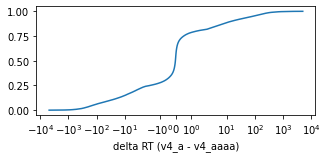

In [310]:
v4_delta = Cdf.MakeCdfFromList(v4_merged['delta_rt'])
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(v4_delta.xs, v4_delta.ps)
ax.set_xscale('symlog')
ax.set_xlabel('delta RT (v4_a - v4_aaaa)');

In [311]:
for x, p in list(zip(v4_delta.xs, v4_delta.ps))[::1000]:
    print(x, p)

-4803.218 3.5340684195646026e-06
-857.162 0.0035376024879841673
-592.548 0.007075204975968335
-454.52299999999997 0.01061987560079163
-367.284 0.014168080294034492
-325.13599999999997 0.01773042126095561
-285.70700000000005 0.021282160022618037
-257.628 0.024844500989539157
-230.99300000000002 0.02839977381962115
-208.682 0.0319691829233814
-190.04899999999998 0.035531523890302515
-174.24800000000002 0.03908679672038451
-158.9435 0.04265973989256432
-145.43200000000002 0.04626095561210065
-133.212 0.04984450098953916
-121.3665 0.05343158043539723
-110.63000000000002 0.05703279615493356
-100.04950000000001 0.06063401187446989
-91.845 0.064277636415041
-82.854 0.0678717839977382
-74.327 0.07144826123833757
-66.57000000000005 0.07506007916313259
-59.601000000000006 0.07866836301950805
-53.426 0.08227311280746395
-48.13900000000001 0.08591320327961549
-43.277 0.08955329375176703
-38.797499999999985 0.09322519083969466
-34.865 0.09694656488549619
-31.409499999999998 0.10068560927339554
-28.

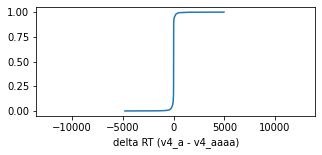

In [312]:
ax.set_xscale('linear')
fig

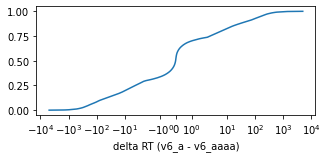

In [313]:
v6_delta = Cdf.MakeCdfFromList(v6_merged['delta_rt'])
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(v6_delta.xs, v6_delta.ps)
ax.set_xscale('symlog')
ax.set_xlabel('delta RT (v6_a - v6_aaaa)');

In [314]:
for x, p in list(zip(v6_delta.xs, v6_delta.ps))[::1000]:
    print(x, p)

-4929.906999999999 5.075498033244512e-06
-835.68 0.005080573531277757
-570.948 0.010166222560588759
-449.076 0.01525187158989976
-372.511 0.02034767161527725
-320.227 0.025448547138687983
-284.503 0.03054942266209872
-254.708 0.03572643065600812
-229.055 0.04082223068138561
-207.52499999999998 0.04593833269889608
-190.175 0.05108996320263926
-172.714 0.056292348686714885
-155.89499999999998 0.06144397919045806
-141.118 0.0666260626824007
-127.44200000000001 0.07179291968024362
-115.341 0.07692424819185383
-104.60149999999999 0.08210633168379647
-95.79899999999999 0.08731379266590535
-88.14500000000001 0.09256185763228017
-80.37500000000001 0.0977997716025885
-72.15799999999999 0.10302753457683035
-64.01899999999999 0.10822484456287274
-57.230999999999995 0.11341707905088187
-51.045 0.1186651440172567
-45.246999999999986 0.1238776804973988
-39.918000000000006 0.12915112295393985
-35.233 0.13442964090851414
-31.13499999999999 0.13972846085522142
-27.401999999999994 0.14495622382946327
-2

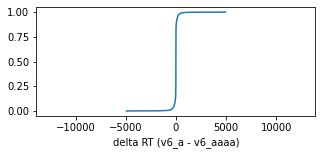

In [315]:
ax.set_xscale('linear')
fig

# =====================================================

## Traceroute Intermediate Hops for ASN

In [157]:
tr_df[tr_df['endpoint'] != '*']['endpoint'].drop_duplicates().to_csv('../metadata/intermediate-hops.csv', index=False, header=False)

In [158]:
tr_asns = pd.read_csv('../metadata/intermediate-hops-asns.csv', sep=';')

In [159]:
tr_asns

,ip,asn,holder
0,192.168.178.1,-1,NO HOLDER
1,194.109.5.177,3265,XS4ALL-NL - Xs4all Internet BV
2,194.109.7.69,3265,XS4ALL-NL - Xs4all Internet BV
3,194.109.5.5,3265,XS4ALL-NL - Xs4all Internet BV
4,80.249.211.140,-1,NO HOLDER
...,...,...,...
25893,2001:470:0:112::1,6939,HURRICANE
25894,2001:470:0:32::2,6939,HURRICANE
25895,2804:d40:80:8014::2,7738,Telemar Norte Leste S.A.
25896,2800:1e0:3000::1,7195,EDGEUNO SAS


In [160]:
tr_asns

,ip,asn,holder
0,192.168.178.1,-1,NO HOLDER
1,194.109.5.177,3265,XS4ALL-NL - Xs4all Internet BV
2,194.109.7.69,3265,XS4ALL-NL - Xs4all Internet BV
3,194.109.5.5,3265,XS4ALL-NL - Xs4all Internet BV
4,80.249.211.140,-1,NO HOLDER
...,...,...,...
25893,2001:470:0:112::1,6939,HURRICANE
25894,2001:470:0:32::2,6939,HURRICANE
25895,2804:d40:80:8014::2,7738,Telemar Norte Leste S.A.
25896,2800:1e0:3000::1,7195,EDGEUNO SAS


In [161]:
tr_asns[tr_asns.duplicated('ip')]

,ip,asn,holder
4826,38.131.180.210,395965,CARRY-TELECOM
4828,38.131.180.209,395965,CARRY-TELECOM
8840,92.47.151.189,50482,KAZAKHTELECOM-AS - JSC Kazakhtelecom
9679,190.211.160.4,262589,INTERNEXA BRASIL OPERADORA DE TELECOMUNICACOES...
9976,116.68.231.74,55794,LYNX-AS-AP PT Lynx Mitra Asia
9978,116.68.230.197,7632,LINKNET-EXCHANGE-AS-ID Linknet-Exchange ASN
11799,116.68.231.205,55794,LYNX-AS-AP PT Lynx Mitra Asia
12532,64.6.64.6,396566,VRSN-AC50-340
12533,64.6.64.6,396549,VRSN-AC50-340
12534,64.6.64.6,396576,VRSN-AC50-340


In [162]:
# only keep first entry for IP address with multiple ASNs
tr_asns = tr_asns.drop_duplicates('ip', keep='first')

In [163]:
tr_as_hops = tr_df.drop(columns=['ip']).merge(tr_asns, left_on='endpoint', right_on='ip', how='left')

In [164]:
tr_as_hops

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,country,continent,resolver_name,ip,asn,holder
0,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,1,192.168.178.1,0.892,NL,EU,Cloudflare,192.168.178.1,-1.0,NO HOLDER
1,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,2,194.109.5.177,19.519,NL,EU,Cloudflare,194.109.5.177,3265.0,XS4ALL-NL - Xs4all Internet BV
2,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,3,194.109.7.69,5.317,NL,EU,Cloudflare,194.109.7.69,3265.0,XS4ALL-NL - Xs4all Internet BV
3,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,4,194.109.5.5,5.076,NL,EU,Cloudflare,194.109.5.5,3265.0,XS4ALL-NL - Xs4all Internet BV
4,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,5,80.249.211.140,11.366,NL,EU,Cloudflare,80.249.211.140,-1.0,NO HOLDER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310993,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,7,2001:ac8:10:10::1a3,28.189,DE,EU,NextDNS,2001:ac8:10:10::1a3,9009.0,M247 - M247 Ltd
310994,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,8,2001:ac8:10:10::303,27.819,DE,EU,NextDNS,2001:ac8:10:10::303,9009.0,M247 - M247 Ltd
310995,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,9,2a0d:5642:115::2,28.373,DE,EU,NextDNS,2a0d:5642:115::2,35487.0,"MISAKA - Misaka Network, Inc."
310996,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,10,*,NaN,DE,EU,NextDNS,NaN,NaN,NaN


In [165]:
x = tr_as_hops.copy()
x['asn'] = x['asn'].replace({-1 : np.nan})
x = x.dropna(subset=['asn'])

# .groupby(['timestamp', 'probe_id', 'dst'], as_index=False).apply(count_as_hops).reset_index()

In [166]:
x

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,country,continent,resolver_name,ip,asn,holder
1,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,2,194.109.5.177,19.519,NL,EU,Cloudflare,194.109.5.177,3265.0,XS4ALL-NL - Xs4all Internet BV
2,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,3,194.109.7.69,5.317,NL,EU,Cloudflare,194.109.7.69,3265.0,XS4ALL-NL - Xs4all Internet BV
3,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,4,194.109.5.5,5.076,NL,EU,Cloudflare,194.109.5.5,3265.0,XS4ALL-NL - Xs4all Internet BV
5,27951715,2020-11-03 15:03:11,icmp-traceroute,10001,4,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,6,6,1.1.1.1,6.636,NL,EU,Cloudflare,1.1.1.1,13335.0,CLOUDFLARENET
8,27951715,2020-11-03 15:03:09,icmp-traceroute,10006,4,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,OK,8,3,62.253.128.109,27.666,GB,EU,Cloudflare,62.253.128.109,5089.0,NTL - Virgin Media Limited
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310991,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,5,2001:2000:3019:6b::1,32.178,DE,EU,NextDNS,2001:2000:3019:6b::1,1299.0,TELIANET - Telia Company AB
310993,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,7,2001:ac8:10:10::1a3,28.189,DE,EU,NextDNS,2001:ac8:10:10::1a3,9009.0,M247 - M247 Ltd
310994,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,8,2001:ac8:10:10::303,27.819,DE,EU,NextDNS,2001:ac8:10:10::303,9009.0,M247 - M247 Ltd
310995,27951734,2020-11-03 15:04:01,icmp-traceroute,55713,6,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,11,9,2a0d:5642:115::2,28.373,DE,EU,NextDNS,2a0d:5642:115::2,35487.0,"MISAKA - Misaka Network, Inc."


In [167]:
x['diff'] = x.groupby(['timestamp', 'probe_id', 'dst'], as_index=False)['asn'].transform(lambda y: y.diff())

In [168]:
x['as_change'] = (x['diff'] != 0)

In [169]:
tr_as_hops['as_change'] = False

In [170]:
tr_as_hops.update(x)

In [171]:
def as_hop_counter(group):
    if len(group[group['holder'] == 'NO HOLDER']) > 2:  # if we have more than two cases of "NO HOLDER", drop this measurement
        return None
    else:
        return group['as_change'].eq(True).cumsum()  # count how often the AS has changed based on boolean column

In [172]:
as_hops = pd.DataFrame()

for _, grp in tr_as_hops.groupby(['timestamp', 'probe_id', 'dst'], as_index=False):
    as_hops = pd.concat([as_hops, as_hop_counter(grp)])

In [173]:
as_hops = as_hops.rename(columns={0 : 'as_hop'})

In [174]:
as_hops

,as_hop
9048,0.0
9049,0.0
9050,0.0
9051,0.0
9052,1.0
...,...
220877,0.0
104481,0.0
130001,0.0
151428,0.0


In [175]:
tr_as_hops = tr_as_hops.merge(as_hops, left_index=True, right_index=True)

In [176]:
tr_as_hops

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,...,endpoint,rtt,country,continent,resolver_name,ip,asn,holder,as_change,as_hop
0,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10001.0,4.0,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,...,192.168.178.1,0.892,NL,EU,Cloudflare,192.168.178.1,-1.0,NO HOLDER,False,0.0
1,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10001.0,4.0,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,...,194.109.5.177,19.519,NL,EU,Cloudflare,194.109.5.177,3265.0,XS4ALL-NL - Xs4all Internet BV,True,1.0
2,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10001.0,4.0,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,...,194.109.7.69,5.317,NL,EU,Cloudflare,194.109.7.69,3265.0,XS4ALL-NL - Xs4all Internet BV,False,1.0
3,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10001.0,4.0,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,...,194.109.5.5,5.076,NL,EU,Cloudflare,194.109.5.5,3265.0,XS4ALL-NL - Xs4all Internet BV,False,1.0
4,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10001.0,4.0,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,...,80.249.211.140,11.366,NL,EU,Cloudflare,80.249.211.140,-1.0,NO HOLDER,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310993,27951734.0,2020-11-03 15:04:01,icmp-traceroute,55713.0,6.0,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,...,2001:ac8:10:10::1a3,28.189,DE,EU,NextDNS,2001:ac8:10:10::1a3,9009.0,M247 - M247 Ltd,True,3.0
310994,27951734.0,2020-11-03 15:04:01,icmp-traceroute,55713.0,6.0,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,...,2001:ac8:10:10::303,27.819,DE,EU,NextDNS,2001:ac8:10:10::303,9009.0,M247 - M247 Ltd,False,3.0
310995,27951734.0,2020-11-03 15:04:01,icmp-traceroute,55713.0,6.0,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,...,2a0d:5642:115::2,28.373,DE,EU,NextDNS,2a0d:5642:115::2,35487.0,"MISAKA - Misaka Network, Inc.",True,4.0
310996,27951734.0,2020-11-03 15:04:01,icmp-traceroute,55713.0,6.0,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a00:79c0:605:9501:1:eff:fe43:e3d9,2a07:a8c0::,2a07:a8c0::,OK,...,*,NaN,DE,EU,NextDNS,NaN,NaN,NaN,False,4.0


In [177]:
tr_as_hops[(tr_as_hops['as_hop'] == 0) & (tr_as_hops['ttl'] == 1)]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,...,endpoint,rtt,country,continent,resolver_name,ip,asn,holder,as_change,as_hop
0,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10001.0,4.0,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,OK,...,192.168.178.1,0.892,NL,EU,Cloudflare,192.168.178.1,-1.0,NO HOLDER,False,0.0
6,27951715.0,2020-11-03 15:03:09,icmp-traceroute,10006.0,4.0,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,OK,...,192.168.0.1,70.503,GB,EU,Cloudflare,192.168.0.1,-1.0,NO HOLDER,False,0.0
14,27951715.0,2020-11-03 15:03:13,icmp-traceroute,10015.0,4.0,185.238.131.3,192.168.178.39,1.1.1.1,1.1.1.1,OK,...,192.168.178.1,0.779,NL,EU,Cloudflare,192.168.178.1,-1.0,NO HOLDER,False,0.0
21,27951715.0,2020-11-03 15:03:12,icmp-traceroute,10022.0,4.0,83.68.21.139,10.71.6.153,1.1.1.1,1.1.1.1,OK,...,10.71.6.12,0.765,NL,EU,Cloudflare,10.71.6.12,-1.0,NO HOLDER,False,0.0
27,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10046.0,4.0,82.217.84.104,192.168.42.45,1.1.1.1,1.1.1.1,OK,...,192.168.42.1,0.563,NL,EU,Cloudflare,192.168.42.1,-1.0,NO HOLDER,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310405,27951734.0,2020-11-03 15:03:36,icmp-traceroute,55477.0,6.0,2a02:a450:23a3:666:1:7fff:fe49:ea69,2a02:a450:23a3:666:1:7fff:fe49:ea69,2a07:a8c0::,2a07:a8c0::,OK,...,2001:67c:2502:f100::2:3e,151.130,NL,EU,NextDNS,2001:67c:2502:f100::2:3e,-1.0,NO HOLDER,False,0.0
310505,27951734.0,2020-11-03 15:03:32,icmp-traceroute,55662.0,6.0,2605:a000:123d:c4:1:4ff:fecc:c7d0,2605:a000:123d:c4:1:4ff:fecc:c7d0,2a07:a8c0::,2a07:a8c0::,OK,...,*,NaN,US,NA,NextDNS,NaN,NaN,NaN,False,0.0
310548,27951734.0,2020-11-03 15:03:27,icmp-traceroute,55688.0,6.0,2600:8800:5b80:67d:1:c4ff:fe54:8497,2600:8800:5b80:350:1:c4ff:fe54:8497,2a07:a8c0::,2a07:a8c0::,OK,...,*,NaN,US,NA,NextDNS,NaN,NaN,NaN,False,0.0
310565,27951734.0,2020-11-03 15:03:34,icmp-traceroute,55704.0,6.0,2a02:587:a615:1900:1:e3ff:fecb:3300,2a02:587:a615:1900:1:e3ff:fecb:3300,2a07:a8c0::,2a07:a8c0::,OK,...,*,NaN,GR,EU,NextDNS,NaN,NaN,NaN,False,0.0


In [178]:
# if first IP hop, set AS hop to 1 as well
tr_as_hops.loc[(tr_as_hops['as_hop'] == 0) & (tr_as_hops['ttl'] == 1), 
               'as_hop'] = 1


In [179]:
tr_as_hops[(tr_as_hops['as_hop'] == 0) & (tr_as_hops['ttl'] == 1)]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,...,endpoint,rtt,country,continent,resolver_name,ip,asn,holder,as_change,as_hop


In [180]:
pd.set_option('max_columns', 25)

In [181]:
tr_as_hops[(tr_as_hops['as_hop'] == 0) & (tr_as_hops['ttl'] != 1)][['ttl', 'as_hop']]

,ttl,as_hop
7,2.0,0.0
28,2.0,0.0
42,2.0,0.0
50,2.0,0.0
51,3.0,0.0
...,...,...
310551,4.0,0.0
310552,5.0,0.0
310553,255.0,0.0
310566,2.0,0.0


In [182]:
tr_as_hops['as_hop'].value_counts()

1.0    125697
2.0     65793
3.0     27178
0.0      8325
4.0      6434
5.0      1196
6.0       124
7.0         6
Name: as_hop, dtype: int64

In [183]:
print(tr_as_hops[['ttl', 'endpoint', 'asn', 'holder', 'as_change', 'as_hop']].head(11))

    ttl        endpoint      asn                          holder as_change  \
0   1.0   192.168.178.1     -1.0                       NO HOLDER     False   
1   2.0   194.109.5.177   3265.0  XS4ALL-NL - Xs4all Internet BV      True   
2   3.0    194.109.7.69   3265.0  XS4ALL-NL - Xs4all Internet BV     False   
3   4.0     194.109.5.5   3265.0  XS4ALL-NL - Xs4all Internet BV     False   
4   5.0  80.249.211.140     -1.0                       NO HOLDER     False   
5   6.0         1.1.1.1  13335.0                   CLOUDFLARENET      True   
6   1.0     192.168.0.1     -1.0                       NO HOLDER     False   
7   2.0               *      NaN                             NaN     False   
8   3.0  62.253.128.109   5089.0      NTL - Virgin Media Limited      True   
9   4.0               *      NaN                             NaN     False   
10  5.0               *      NaN                             NaN     False   

    as_hop  
0      1.0  
1      1.0  
2      1.0  
3      1.0 

In [186]:
tr_as_hops.dtypes

msm_id                   float64
timestamp         datetime64[ns]
method                    object
probe_id                 float64
addr_fam                 float64
origin                    object
src                       object
dst                       object
dst_name                  object
status                    object
ip_path_length           float64
ttl                      float64
endpoint                  object
rtt                      float64
country                   object
continent                 object
resolver_name             object
ip                        object
asn                      float64
holder                    object
as_change                 object
as_hop                   float64
dtype: object

In [187]:
tr_as_hops_paths = tr_as_hops[
    (tr_as_hops['ip_path_length'] == tr_as_hops['ttl'])
    & (tr_as_hops['status'] == 'OK')
    & (tr_as_hops['dst'] == tr_as_hops['endpoint'])
]

tr_as_hops_paths = tr_as_hops_paths[['msm_id',
                                     'timestamp',
                                     'method',
                                     'probe_id',
                                     'country',
                                     'continent',
                                     'addr_fam',
                                     'origin',
                                     'src',
                                     'dst',
                                     'dst_name',
                                     'resolver_name',
                                     'status',
                                     'ip_path_length',
                                     'ttl',
                                     'endpoint',
                                     'rtt',
                                     'asn',
                                     'holder',
                                     'as_hop']
                                   ]

In [188]:
tr_as_hops_paths

,msm_id,timestamp,method,probe_id,country,continent,addr_fam,origin,src,dst,dst_name,resolver_name,status,ip_path_length,ttl,endpoint,rtt,asn,holder,as_hop
5,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10001.0,NL,EU,4.0,82.95.114.207,192.168.178.30,1.1.1.1,1.1.1.1,Cloudflare,OK,6.0,6.0,1.1.1.1,6.636,13335.0,CLOUDFLARENET,2.0
13,27951715.0,2020-11-03 15:03:09,icmp-traceroute,10006.0,GB,EU,4.0,80.5.131.205,192.168.0.31,1.1.1.1,1.1.1.1,Cloudflare,OK,8.0,8.0,1.1.1.1,76.733,13335.0,CLOUDFLARENET,2.0
20,27951715.0,2020-11-03 15:03:13,icmp-traceroute,10015.0,NL,EU,4.0,185.238.131.3,192.168.178.39,1.1.1.1,1.1.1.1,Cloudflare,OK,7.0,7.0,1.1.1.1,2.381,13335.0,CLOUDFLARENET,3.0
26,27951715.0,2020-11-03 15:03:12,icmp-traceroute,10022.0,NL,EU,4.0,83.68.21.139,10.71.6.153,1.1.1.1,1.1.1.1,Cloudflare,OK,6.0,6.0,1.1.1.1,5.239,13335.0,CLOUDFLARENET,2.0
35,27951715.0,2020-11-03 15:03:11,icmp-traceroute,10046.0,NL,EU,4.0,82.217.84.104,192.168.42.45,1.1.1.1,1.1.1.1,Cloudflare,OK,9.0,9.0,1.1.1.1,12.738,13335.0,CLOUDFLARENET,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310954,27951734.0,2020-11-03 15:04:00,icmp-traceroute,54143.0,NL,EU,6.0,2001:981:f823:1:1:dff:fe08:5119,2001:981:f823:1:1:dff:fe08:5119,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,11.0,11.0,2a07:a8c0::,9.627,34939.0,"NEXTDNS - nextdns, Inc.",4.0
310966,27951734.0,2020-11-03 15:04:01,icmp-traceroute,54470.0,US,NA,6.0,2601:647:4700:d33:1:9fff:fe75:991d,2601:647:4700:d33:1:9fff:fe75:991d,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,12.0,12.0,2a07:a8c0::,13.605,34939.0,"NEXTDNS - nextdns, Inc.",4.0
310977,27951734.0,2020-11-03 15:04:00,icmp-traceroute,55364.0,FR,EU,6.0,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a01:e34:efc2:76b0:1:beff:fe4b:4ced,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,11.0,11.0,2a07:a8c0::,17.069,34939.0,"NEXTDNS - nextdns, Inc.",4.0
310986,27951734.0,2020-11-03 15:04:00,icmp-traceroute,55401.0,NO,EU,6.0,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,2a07:a8c0::,2a07:a8c0::,NextDNS,OK,9.0,9.0,2a07:a8c0::,19.170,34939.0,"NEXTDNS - nextdns, Inc.",5.0


In [189]:
pd.crosstab(tr_as_hops_paths['resolver_name'],tr_as_hops_paths['as_hop'])

as_hop,1.0,2.0,3.0,4.0,5.0,6.0,7.0
resolver_name,,,,,,,
CleanBrowsing,43,521,985,498,82,4,0
Cloudflare,128,1286,988,111,30,1,0
Google,73,2023,406,40,4,1,0
Neustar UltraRecursive,40,43,1762,652,91,10,1
NextDNS,40,409,900,565,325,48,5
OpenDNS,52,871,1046,369,46,1,0
OpenNIC,43,460,900,448,151,5,0
Quad9,70,1305,780,147,10,1,0
VeriSign,54,418,1095,663,163,28,0


In [190]:
tr_as_path_overview = pd.DataFrame(pd.crosstab(tr_as_hops_paths['resolver_name'],tr_as_hops_paths['as_hop']))
tr_as_path_overview['total'] = tr_as_path_overview.sum(axis=1)

In [191]:
for col in tr_as_path_overview.columns[:-1]:
    tr_as_path_overview[col] = tr_as_path_overview[col]/tr_as_path_overview['total'] * 100

In [192]:
tr_as_path_overview.round(1)

as_hop,1.0,2.0,3.0,4.0,5.0,6.0,7.0,total
resolver_name,,,,,,,,
CleanBrowsing,2.0,24.4,46.2,23.3,3.8,0.2,0.0,2133
Cloudflare,5.0,50.6,38.8,4.4,1.2,0.0,0.0,2544
Google,2.9,79.4,15.9,1.6,0.2,0.0,0.0,2547
Neustar UltraRecursive,1.5,1.7,67.8,25.1,3.5,0.4,0.0,2599
NextDNS,1.7,17.8,39.3,24.7,14.2,2.1,0.2,2292
OpenDNS,2.2,36.5,43.9,15.5,1.9,0.0,0.0,2385
OpenNIC,2.1,22.9,44.8,22.3,7.5,0.2,0.0,2007
Quad9,3.0,56.4,33.7,6.4,0.4,0.0,0.0,2313
VeriSign,2.2,17.3,45.2,27.4,6.7,1.2,0.0,2421


In [193]:
conn = sqlite3.connect('../data/ripe-agg.db')
tr_as_hops_paths.to_sql('traceroute_as', con=conn, index=False, if_exists='replace')
conn.close()

In [194]:
tr_df.msm_id.unique()

array([27951715, 27951716, 27951717, 27951718, 27951719, 27951720,
       27951721, 27951722, 27951723, 27951724, 27951725, 27951726,
       27951727, 27951728, 27951729, 27951730, 27951731, 27951732,
       27951733, 27951734])

In [195]:
tr_df.method.unique()

array(['icmp-traceroute'], dtype=object)

In [196]:
tr_df.timestamp.dt.floor('D').value_counts()

2020-11-03    310882
2020-11-04       106
2020-11-05        10
Name: timestamp, dtype: int64

# =====================================================

## Traces to local resolvers

In [197]:
local_tr = pd.read_csv('../data/traceroute-results-local.csv', sep='|')

In [198]:
local_tr['dst_name'].unique()

array(['0:0:53f9:459f::1', '1.0.0.1', '1.0.0.3', '1.1.0.1', '1.1.1.3',
       '103.58.228.2', '103.58.229.2', '109.0.66.10', '109.0.66.20',
       '109.195.16.1', '109.197.192.1', '109.197.192.78',
       '109.237.224.20', '109.237.224.21', '109.247.114.4',
       '109.88.203.3', '114.114.114.114', '119.42.152.5',
       '122.197.254.136', '132.147.113.3', '138.201.66.172',
       '141.0.144.2', '141.10.85.129', '148.122.16.253',
       '148.122.164.253', '149.112.112.112', '151.5.216.15',
       '151.5.216.150', '156.154.70.3', '156.154.70.5', '162.223.13.118',
       '164.124.101.2', '165.169.76.108', '168.126.63.1', '168.126.63.2',
       '169.239.0.20', '169.239.0.30', '169.55.51.86', '172.168.24.22',
       '172.168.24.80', '172.50.1.1', '172.64.36.1', '172.64.36.2',
       '175.100.191.221', '176.103.130.130', '176.103.130.131',
       '176.95.16.250', '176.95.16.251', '177.92.29.202', '181.213.132.4',
       '181.213.132.5', '181.45.64.77', '181.47.248.145',
       '181.47.254.1

In [199]:
local_tr

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt
0,27950443,1604414236,icmp-traceroute,54990,6,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1,1,0:0:53f9:459f::1,0.967
1,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,1,192.168.1.1,1.554
2,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,2,10.24.49.134,5.213
3,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,3,*,NaN
4,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,4,91.183.241.200,7.304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8960,27951542,1604414854,icmp-traceroute,26911,4,94.46.95.78,192.168.141.196,95.131.96.254,95.131.96.254,OK,7,6,*,NaN
8961,27951542,1604414854,icmp-traceroute,26911,4,94.46.95.78,192.168.141.196,95.131.96.254,95.131.96.254,OK,7,7,95.131.96.254,97.614
8962,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,1,10.1.0.1,0.556
8963,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,2,96.76.225.35,0.655


In [200]:
local_tr[local_tr.duplicated()]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt


In [201]:
len(local_tr['dst_name'].unique())

957

In [202]:
local_resolvers = pd.read_csv('../metadata/local-resolvers-asns.csv', sep=';')

In [203]:
local_resolvers = local_resolvers.drop_duplicates('ip')

In [204]:
local_resolvers

,ip,asn,holder
0,0:0:53f9:459f::1,-1,NO HOLDER
1,1.0.0.1,13335,CLOUDFLARENET
2,1.0.0.3,13335,CLOUDFLARENET
3,1.1.0.1,-1,NO HOLDER
4,1.1.1.3,13335,CLOUDFLARENET
...,...,...,...
972,94.140.66.194,3212,TELEMACH - Telemach UG d.o.o.
973,94.254.0.147,8473,BAHNHOF - Bahnhof AB
974,95.131.96.254,12897,ENTEGAMEDIANET - ENTEGA Medianet GmbH
975,96.76.225.35,7922,COMCAST-7922


In [205]:
local_resolvers[local_resolvers.holder.isnull()]

,ip,asn,holder
477,24.116.0.53,645190,NaN
478,24.116.2.50,645190,NaN


In [206]:
local_resolvers[['holder']] = local_resolvers[['holder']].fillna(value='UNKNOWN HOLDER')

In [207]:
local_resolvers[local_resolvers.holder.str.contains('nextdns')]

,ip,asn,holder
815,2a07:a8c0::c4:463a,34939,"NEXTDNS - nextdns, Inc."
816,2a07:a8c1::c4:463a,34939,"NEXTDNS - nextdns, Inc."
847,45.90.28.112,34939,"NEXTDNS - nextdns, Inc."
848,45.90.28.204,34939,"NEXTDNS - nextdns, Inc."
849,45.90.28.215,34939,"NEXTDNS - nextdns, Inc."
850,45.90.30.112,34939,"NEXTDNS - nextdns, Inc."
851,45.90.30.204,34939,"NEXTDNS - nextdns, Inc."
852,45.90.30.215,34939,"NEXTDNS - nextdns, Inc."


In [208]:
resolver_set = ['clean', 'cloudflare', 'google', 'opendns', 'opennic', 'quad', 'verisign', 'yandex', 'neustar', 'silent', 'nextdns']
# opennic announced by "SILENT-GHOST-AS - Kevin Holly trading as Silent Ghost e.U."

centralized_resolvers = pd.DataFrame()

for r in resolver_set:
    centralized_resolvers = pd.concat([centralized_resolvers, local_resolvers[local_resolvers['holder'].str.lower().str.contains(r)]])

In [209]:
centralized_resolvers  # these are the centralized resolvers that are configured as default resolvers for some probes

,ip,asn,holder
1,1.0.0.1,13335,CLOUDFLARENET
2,1.0.0.3,13335,CLOUDFLARENET
4,1.1.1.3,13335,CLOUDFLARENET
43,172.64.36.1,13335,CLOUDFLARENET
44,172.64.36.2,13335,CLOUDFLARENET
556,2606:4700:4700::1001,13335,CLOUDFLARENET
251,2001:4860:4860::8844,15169,GOOGLE
553,2605:a601:51f8:4803:d6be:d9ff:feed:c816,16591,GOOGLE-FIBER
917,8.8.4.4,15169,GOOGLE
405,208.67.220.123,36692,OPENDNS


In [210]:
centralized_resolvers['asn'].unique()

array([13335, 15169, 16591, 36692, 19281, 13238, 34939])

In [212]:
local_tr = local_tr.merge(local_resolvers, left_on='dst', right_on='ip')

In [213]:
local_tr

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,ip,asn,holder
0,27950443,1604414236,icmp-traceroute,54990,6,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1,1,0:0:53f9:459f::1,0.967,0:0:53f9:459f::1,-1,NO HOLDER
1,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,1,192.168.1.1,1.554,1.0.0.1,13335,CLOUDFLARENET
2,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,2,10.24.49.134,5.213,1.0.0.1,13335,CLOUDFLARENET
3,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,3,*,NaN,1.0.0.1,13335,CLOUDFLARENET
4,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,4,91.183.241.200,7.304,1.0.0.1,13335,CLOUDFLARENET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8960,27951542,1604414854,icmp-traceroute,26911,4,94.46.95.78,192.168.141.196,95.131.96.254,95.131.96.254,OK,7,6,*,NaN,95.131.96.254,12897,ENTEGAMEDIANET - ENTEGA Medianet GmbH
8961,27951542,1604414854,icmp-traceroute,26911,4,94.46.95.78,192.168.141.196,95.131.96.254,95.131.96.254,OK,7,7,95.131.96.254,97.614,95.131.96.254,12897,ENTEGAMEDIANET - ENTEGA Medianet GmbH
8962,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,1,10.1.0.1,0.556,96.76.225.35,7922,COMCAST-7922
8963,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,2,96.76.225.35,0.655,96.76.225.35,7922,COMCAST-7922


In [214]:
# NOTE: probes that use one of the main centralized resolver services (8.8.8.8, 1.1.1.1, ...)
# are missing from here!
local_tr['centralized_resolver'] = local_tr['asn'].isin(centralized_resolvers['asn'].unique()).astype('bool')

In [215]:
local_tr = local_tr.merge(probes_country, on='probe_id')

In [216]:
local_tr

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,ip,asn,holder,centralized_resolver,country,continent
0,27950443,1604414236,icmp-traceroute,54990,6,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1,1,0:0:53f9:459f::1,0.967,0:0:53f9:459f::1,-1,NO HOLDER,False,SE,EU
1,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,1,192.168.1.1,1.554,1.0.0.1,13335,CLOUDFLARENET,True,BE,EU
2,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,2,10.24.49.134,5.213,1.0.0.1,13335,CLOUDFLARENET,True,BE,EU
3,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,3,*,NaN,1.0.0.1,13335,CLOUDFLARENET,True,BE,EU
4,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,4,91.183.241.200,7.304,1.0.0.1,13335,CLOUDFLARENET,True,BE,EU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8938,27951539,1604414854,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3,2,94.139.204.1,1.473,94.139.204.10,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU
8939,27951539,1604414854,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3,3,94.139.204.10,1.584,94.139.204.10,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU
8940,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,1,10.1.0.1,0.556,96.76.225.35,7922,COMCAST-7922,False,US,NA
8941,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,2,96.76.225.35,0.655,96.76.225.35,7922,COMCAST-7922,False,US,NA


In [217]:
local_tr_paths = local_tr[
    (local_tr['ip_path_length'] == local_tr['ttl'])
    & (local_tr['status'] == 'OK')
    & (local_tr['dst'] == local_tr['endpoint'])
]

In [218]:
local_tr_paths

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,ip,asn,holder,centralized_resolver,country,continent
0,27950443,1604414236,icmp-traceroute,54990,6,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1,1,0:0:53f9:459f::1,0.967,0:0:53f9:459f::1,-1,NO HOLDER,False,SE,EU
6,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,6,1.0.0.1,8.248,1.0.0.1,13335,CLOUDFLARENET,True,BE,EU
11,27950444,1604414236,icmp-traceroute,11673,4,203.119.77.248,192.168.230.31,1.0.0.1,1.0.0.1,OK,5,5,1.0.0.1,1.025,1.0.0.1,13335,CLOUDFLARENET,True,AU,OC
16,27950444,1604414236,icmp-traceroute,11724,4,85.208.144.20,10.10.11.247,1.0.0.1,1.0.0.1,OK,5,5,1.0.0.1,6.944,1.0.0.1,13335,CLOUDFLARENET,True,FR,EU
21,27951080,1604414597,icmp-traceroute,11724,6,2a09:8740:20ae:0:fa1a:67ff:fe4d:76a3,2a09:8740:20ae:0:fa1a:67ff:fe4d:76a3,2606:4700:4700::1001,2606:4700:4700::1001,OK,5,5,2606:4700:4700::1001,7.360,2606:4700:4700::1001,13335,CLOUDFLARENET,True,FR,EU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8928,27951534,1604414849,icmp-traceroute,31518,4,91.231.25.217,10.9.217.246,91.231.24.4,91.231.24.4,OK,2,2,91.231.24.4,2.749,91.231.24.4,197979,INTERKAR-AS - INTERKAR KOMPUTER - SERWIS Karol...,False,PL,EU
8934,27951537,1604414853,icmp-traceroute,53805,4,51.174.100.89,192.168.1.43,92.220.228.70,92.220.228.70,OK,6,6,92.220.228.70,1.672,92.220.228.70,29695,ALTIBOX_AS - Altibox AS,False,NO,EU
8936,27951538,1604414853,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.1,94.139.204.1,OK,2,2,94.139.204.1,0.755,94.139.204.1,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU
8939,27951539,1604414854,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3,3,94.139.204.10,1.584,94.139.204.10,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU


In [219]:
v4_local_tr_paths = local_tr_paths[local_tr_paths['addr_fam'] == 4]
v6_local_tr_paths = local_tr_paths[local_tr_paths['addr_fam'] == 6]

In [220]:
len(v4_local_tr_paths)

760

In [221]:
len(v6_local_tr_paths)

443

In [222]:
len(local_tr_paths['probe_id'].unique())

802

In [223]:
# number of traces to centralized resolvers overall
local_tr_paths[local_tr_paths['centralized_resolver']]['holder'].value_counts()

GOOGLE                     112
CLOUDFLARENET               88
OPENDNS                     69
NEXTDNS - nextdns, Inc.      8
QUAD9-AS-1                   8
YANDEX - YANDEX LLC          6
GOOGLE-FIBER                 1
Name: holder, dtype: int64

In [224]:
# number of traces to centralized resolvers UNIQUE BY PROBE
local_tr_paths[local_tr_paths['centralized_resolver']].drop_duplicates('probe_id')['holder'].value_counts()

GOOGLE                     111
CLOUDFLARENET               80
OPENDNS                     46
QUAD9-AS-1                   8
NEXTDNS - nextdns, Inc.      4
YANDEX - YANDEX LLC          3
Name: holder, dtype: int64

In [225]:
# "ISP" resolvers
local_tr_paths[~local_tr_paths['centralized_resolver']]['holder'].value_counts()

LIBERTYGLOBAL - Liberty Global B.V.       60
COMCAST-7922                              57
HURRICANE                                 51
AS3215 - Orange S.A.                      42
PROXAD - Free SAS                         33
                                          ..
ICNDP-AS-KR Namincheon Brodcasting Co.     1
GRENODE - Grenode                          1
TWC-11351-NORTHEAST                        1
IWAY - Iway AG                             1
METRONET - METRONET s.r.o.                 1
Name: holder, Length: 234, dtype: int64

In [226]:
# number of paths for which ISP resolvers were traceable
local_tr_paths[~local_tr_paths['centralized_resolver']]['country'].value_counts()

US    140
FR    126
DE     71
NL     53
GB     50
CA     43
BE     38
FI     37
CH     34
CZ     31
RU     28
NO     23
AU     22
SE     18
AR     17
GR     16
DK     12
PL     12
AT     11
ES      9
NZ      9
JP      8
SG      7
IT      7
BO      7
KR      6
BG      6
CL      6
BR      6
IN      5
EE      4
IL      4
IR      4
SI      4
ID      3
UA      3
PT      3
HU      3
RS      2
BA      2
RE      2
SK      2
PR      2
ZA      2
KE      2
TZ      2
LU      2
CO      2
TH      1
CR      1
RO      1
HR      1
MX      1
Name: country, dtype: int64

In [227]:
# number of publicly reachable ISP resolvers by country
local_tr_paths[~local_tr_paths['centralized_resolver']].drop_duplicates('holder')['country'].value_counts()

US    31
DE    21
FR    13
CZ    12
CH    11
RU    11
GB    10
NL     9
CA     8
FI     7
SE     6
NZ     5
AU     5
NO     5
DK     5
JP     5
BG     4
SG     4
KR     4
BR     3
CL     3
EE     3
GR     3
IN     3
IT     3
SI     3
BE     3
ES     3
BO     3
PL     3
PT     2
UA     2
BA     2
ID     2
IL     2
PR     1
CR     1
TH     1
HR     1
RS     1
RE     1
TZ     1
CO     1
SK     1
IR     1
LU     1
KE     1
MX     1
AT     1
AR     1
Name: country, dtype: int64

In [228]:
local_tr['endpoint'].unique()

array(['0:0:53f9:459f::1', '192.168.1.1', '10.24.49.134', ...,
       '94.139.204.1', '94.139.204.10', '96.76.225.35'], dtype=object)

In [229]:
local_tr[local_tr['endpoint'] != '*']['endpoint'].drop_duplicates().to_csv('../metadata/intermediate-hops-LOCAL.csv', index=False, header=False)

In [230]:
local_tr['is_probe_resolver'] = True

In [231]:
local_tr = local_tr.rename(columns = {'asn' : 'resolver_asn',
                                      'holder' : 'resolver_holder'}
                          ).drop(columns=['ip'])

In [232]:
local_tr

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,resolver_asn,resolver_holder,centralized_resolver,country,continent,is_probe_resolver
0,27950443,1604414236,icmp-traceroute,54990,6,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1,1,0:0:53f9:459f::1,0.967,-1,NO HOLDER,False,SE,EU,True
1,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,1,192.168.1.1,1.554,13335,CLOUDFLARENET,True,BE,EU,True
2,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,2,10.24.49.134,5.213,13335,CLOUDFLARENET,True,BE,EU,True
3,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,3,*,NaN,13335,CLOUDFLARENET,True,BE,EU,True
4,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,4,91.183.241.200,7.304,13335,CLOUDFLARENET,True,BE,EU,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8938,27951539,1604414854,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3,2,94.139.204.1,1.473,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True
8939,27951539,1604414854,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3,3,94.139.204.10,1.584,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True
8940,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,1,10.1.0.1,0.556,7922,COMCAST-7922,False,US,NA,True
8941,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,2,96.76.225.35,0.655,7922,COMCAST-7922,False,US,NA,True


In [233]:
local_tr_asns = pd.read_csv('../metadata/intermediate-hops-asns-LOCAL.csv', sep=';')

In [234]:
local_tr_asns = local_tr_asns.drop_duplicates('ip')

In [235]:
local_tr_as_hops = local_tr.merge(local_tr_asns, left_on='endpoint', right_on='ip', how='left')

In [236]:
local_tr_as_hops

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,resolver_asn,resolver_holder,centralized_resolver,country,continent,is_probe_resolver,ip,asn,holder
0,27950443,1604414236,icmp-traceroute,54990,6,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1,1,0:0:53f9:459f::1,0.967,-1,NO HOLDER,False,SE,EU,True,0:0:53f9:459f::1,-1.0,NO HOLDER
1,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,1,192.168.1.1,1.554,13335,CLOUDFLARENET,True,BE,EU,True,192.168.1.1,-1.0,NO HOLDER
2,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,2,10.24.49.134,5.213,13335,CLOUDFLARENET,True,BE,EU,True,10.24.49.134,-1.0,NO HOLDER
3,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,3,*,NaN,13335,CLOUDFLARENET,True,BE,EU,True,NaN,NaN,NaN
4,27950444,1604414237,icmp-traceroute,11526,4,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6,4,91.183.241.200,7.304,13335,CLOUDFLARENET,True,BE,EU,True,91.183.241.200,5432.0,PROXIMUS-ISP-AS - Proximus NV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8938,27951539,1604414854,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3,2,94.139.204.1,1.473,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True,94.139.204.1,48747.0,LUKOVITNET - Lukovitnet Ltd.
8939,27951539,1604414854,icmp-traceroute,16226,4,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3,3,94.139.204.10,1.584,48747,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True,94.139.204.10,48747.0,LUKOVITNET - Lukovitnet Ltd.
8940,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,1,10.1.0.1,0.556,7922,COMCAST-7922,False,US,NA,True,10.1.0.1,-1.0,NO HOLDER
8941,27951544,1604414857,icmp-traceroute,11513,4,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2,2,96.76.225.35,0.655,7922,COMCAST-7922,False,US,NA,True,96.76.225.35,7922.0,COMCAST-7922


In [237]:
z = local_tr_as_hops.copy()
z['asn'] = z['asn'].replace({-1 : np.nan})
z = z.dropna(subset=['asn'])
z['diff'] = z.groupby(['timestamp', 'probe_id', 'dst'], as_index=False)['asn'].transform(lambda y: y.diff())
z['as_change'] = (z['diff'] != 0)
local_tr_as_hops['as_change'] = False
local_tr_as_hops.update(z)


local_as_hops = pd.DataFrame()
for _, grp in local_tr_as_hops.groupby(['timestamp', 'probe_id', 'dst'], as_index=False):
    local_as_hops = pd.concat([local_as_hops, as_hop_counter(grp)])

local_as_hops = local_as_hops.rename(columns={0 : 'as_hop'})
local_tr_as_hops = local_tr_as_hops.merge(local_as_hops, left_index=True, right_index=True)

local_tr_as_hops

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,resolver_asn,resolver_holder,centralized_resolver,country,continent,is_probe_resolver,ip,asn,holder,as_change,as_hop
0,27950443.0,1.604414e+09,icmp-traceroute,54990.0,6.0,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1.0,1.0,0:0:53f9:459f::1,0.967,-1.0,NO HOLDER,False,SE,EU,True,0:0:53f9:459f::1,-1.0,NO HOLDER,False,0.0
1,27950444.0,1.604414e+09,icmp-traceroute,11526.0,4.0,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6.0,1.0,192.168.1.1,1.554,13335.0,CLOUDFLARENET,True,BE,EU,True,192.168.1.1,-1.0,NO HOLDER,False,0.0
2,27950444.0,1.604414e+09,icmp-traceroute,11526.0,4.0,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6.0,2.0,10.24.49.134,5.213,13335.0,CLOUDFLARENET,True,BE,EU,True,10.24.49.134,-1.0,NO HOLDER,False,0.0
3,27950444.0,1.604414e+09,icmp-traceroute,11526.0,4.0,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6.0,3.0,*,NaN,13335.0,CLOUDFLARENET,True,BE,EU,True,NaN,NaN,NaN,False,0.0
4,27950444.0,1.604414e+09,icmp-traceroute,11526.0,4.0,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6.0,4.0,91.183.241.200,7.304,13335.0,CLOUDFLARENET,True,BE,EU,True,91.183.241.200,5432.0,PROXIMUS-ISP-AS - Proximus NV,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8938,27951539.0,1.604415e+09,icmp-traceroute,16226.0,4.0,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3.0,2.0,94.139.204.1,1.473,48747.0,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True,94.139.204.1,48747.0,LUKOVITNET - Lukovitnet Ltd.,True,1.0
8939,27951539.0,1.604415e+09,icmp-traceroute,16226.0,4.0,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3.0,3.0,94.139.204.10,1.584,48747.0,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True,94.139.204.10,48747.0,LUKOVITNET - Lukovitnet Ltd.,False,1.0
8940,27951544.0,1.604415e+09,icmp-traceroute,11513.0,4.0,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2.0,1.0,10.1.0.1,0.556,7922.0,COMCAST-7922,False,US,NA,True,10.1.0.1,-1.0,NO HOLDER,False,0.0
8941,27951544.0,1.604415e+09,icmp-traceroute,11513.0,4.0,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2.0,2.0,96.76.225.35,0.655,7922.0,COMCAST-7922,False,US,NA,True,96.76.225.35,7922.0,COMCAST-7922,True,1.0


In [238]:
local_tr_as_hops[(local_tr_as_hops['as_hop'] == 0) & (local_tr_as_hops['ttl'] == 1)]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,resolver_asn,resolver_holder,centralized_resolver,country,continent,is_probe_resolver,ip,asn,holder,as_change,as_hop
0,27950443.0,1.604414e+09,icmp-traceroute,54990.0,6.0,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1.0,1.0,0:0:53f9:459f::1,0.967,-1.0,NO HOLDER,False,SE,EU,True,0:0:53f9:459f::1,-1.0,NO HOLDER,False,0.0
1,27950444.0,1.604414e+09,icmp-traceroute,11526.0,4.0,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6.0,1.0,192.168.1.1,1.554,13335.0,CLOUDFLARENET,True,BE,EU,True,192.168.1.1,-1.0,NO HOLDER,False,0.0
7,27950444.0,1.604414e+09,icmp-traceroute,11673.0,4.0,203.119.77.248,192.168.230.31,1.0.0.1,1.0.0.1,OK,5.0,1.0,192.168.230.252,0.561,13335.0,CLOUDFLARENET,True,AU,OC,True,192.168.230.252,-1.0,NO HOLDER,False,0.0
22,27950444.0,1.604414e+09,icmp-traceroute,12071.0,4.0,188.155.37.84,192.168.1.22,1.0.0.1,1.0.0.1,OK,6.0,1.0,192.168.1.1,0.561,13335.0,CLOUDFLARENET,True,CH,EU,True,192.168.1.1,-1.0,NO HOLDER,False,0.0
28,27950444.0,1.604414e+09,icmp-traceroute,12180.0,4.0,69.139.117.20,172.18.19.186,1.0.0.1,1.0.0.1,OK,6.0,1.0,172.18.19.1,0.550,13335.0,CLOUDFLARENET,True,US,NA,True,172.18.19.1,-1.0,NO HOLDER,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8929,27951537.0,1.604415e+09,icmp-traceroute,53805.0,4.0,51.174.100.89,192.168.1.43,92.220.228.70,92.220.228.70,OK,6.0,1.0,192.168.1.1,1.081,29695.0,ALTIBOX_AS - Altibox AS,False,NO,EU,True,192.168.1.1,-1.0,NO HOLDER,False,0.0
8935,27951538.0,1.604415e+09,icmp-traceroute,16226.0,4.0,94.139.206.182,192.168.88.254,94.139.204.1,94.139.204.1,OK,2.0,1.0,192.168.88.1,1.425,48747.0,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True,192.168.88.1,-1.0,NO HOLDER,False,0.0
8937,27951539.0,1.604415e+09,icmp-traceroute,16226.0,4.0,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3.0,1.0,192.168.88.1,0.876,48747.0,LUKOVITNET - Lukovitnet Ltd.,False,BG,EU,True,192.168.88.1,-1.0,NO HOLDER,False,0.0
8940,27951544.0,1.604415e+09,icmp-traceroute,11513.0,4.0,96.76.225.45,10.1.0.71,96.76.225.35,96.76.225.35,OK,2.0,1.0,10.1.0.1,0.556,7922.0,COMCAST-7922,False,US,NA,True,10.1.0.1,-1.0,NO HOLDER,False,0.0


In [239]:
# if first IP hop, set AS hop to 1 as well
local_tr_as_hops.loc[(local_tr_as_hops['as_hop'] == 0) & (local_tr_as_hops['ttl'] == 1), 
               'as_hop'] = 1

In [240]:
local_tr_as_hops[(local_tr_as_hops['as_hop'] == 0) & (local_tr_as_hops['ttl'] == 1)]

,msm_id,timestamp,method,probe_id,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,resolver_asn,resolver_holder,centralized_resolver,country,continent,is_probe_resolver,ip,asn,holder,as_change,as_hop


In [241]:
local_tr_as_hops[(local_tr_as_hops['as_hop'] == 0) & (local_tr_as_hops['ttl'] != 1)][['ttl', 'as_hop']]

,ttl,as_hop
2,2.0,0.0
3,3.0,0.0
23,2.0,0.0
24,3.0,0.0
35,2.0,0.0
...,...,...
8869,2.0,0.0
8889,2.0,0.0
8890,3.0,0.0
8893,2.0,0.0


In [242]:
local_tr_as_hops['as_hop'].value_counts()

1.0    5515
2.0     849
0.0     394
3.0     298
4.0      50
5.0      12
Name: as_hop, dtype: int64

In [243]:
list(local_tr_as_hops.columns)

['msm_id',
 'timestamp',
 'method',
 'probe_id',
 'addr_fam',
 'origin',
 'src',
 'dst',
 'dst_name',
 'status',
 'ip_path_length',
 'ttl',
 'endpoint',
 'rtt',
 'resolver_asn',
 'resolver_holder',
 'centralized_resolver',
 'country',
 'continent',
 'is_probe_resolver',
 'ip',
 'asn',
 'holder',
 'as_change',
 'as_hop']

In [244]:
local_tr_as_hops_paths = local_tr_as_hops[
    (local_tr_as_hops['ip_path_length'] == local_tr_as_hops['ttl'])
    & (local_tr_as_hops['status'] == 'OK')
    & (local_tr_as_hops['dst'] == local_tr_as_hops['endpoint'])
]

local_tr_as_hops_paths = local_tr_as_hops_paths[
    ['msm_id',
     'timestamp',
     'method',
     'probe_id',
     'country',
     'continent',
     'centralized_resolver',
     'is_probe_resolver',
     'resolver_asn',
     'resolver_holder',
     'addr_fam',
     'origin',
     'src',
     'dst',
     'dst_name',
     'status',
     'ip_path_length',
     'ttl',
     'endpoint',
     'rtt',
     'as_hop']
]

In [245]:
local_tr_as_hops_paths

,msm_id,timestamp,method,probe_id,country,continent,centralized_resolver,is_probe_resolver,resolver_asn,resolver_holder,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,as_hop
0,27950443.0,1.604414e+09,icmp-traceroute,54990.0,SE,EU,False,True,-1.0,NO HOLDER,6.0,::53f9:459f:1:3bff:fe13:712d,::53f9:459f:1:3bff:fe13:712d,0:0:53f9:459f::1,0:0:53f9:459f::1,OK,1.0,1.0,0:0:53f9:459f::1,0.967,1.0
6,27950444.0,1.604414e+09,icmp-traceroute,11526.0,BE,EU,True,True,13335.0,CLOUDFLARENET,4.0,81.242.170.220,192.168.1.254,1.0.0.1,1.0.0.1,OK,6.0,6.0,1.0.0.1,8.248,2.0
11,27950444.0,1.604414e+09,icmp-traceroute,11673.0,AU,OC,True,True,13335.0,CLOUDFLARENET,4.0,203.119.77.248,192.168.230.31,1.0.0.1,1.0.0.1,OK,5.0,5.0,1.0.0.1,1.025,3.0
21,27951080.0,1.604415e+09,icmp-traceroute,11724.0,FR,EU,True,True,13335.0,CLOUDFLARENET,6.0,2a09:8740:20ae:0:fa1a:67ff:fe4d:76a3,2a09:8740:20ae:0:fa1a:67ff:fe4d:76a3,2606:4700:4700::1001,2606:4700:4700::1001,OK,5.0,5.0,2606:4700:4700::1001,7.360,2.0
27,27950444.0,1.604414e+09,icmp-traceroute,12071.0,CH,EU,True,True,13335.0,CLOUDFLARENET,4.0,188.155.37.84,192.168.1.22,1.0.0.1,1.0.0.1,OK,6.0,6.0,1.0.0.1,1.508,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8928,27951534.0,1.604415e+09,icmp-traceroute,31518.0,PL,EU,False,True,197979.0,INTERKAR-AS - INTERKAR KOMPUTER - SERWIS Karol...,4.0,91.231.25.217,10.9.217.246,91.231.24.4,91.231.24.4,OK,2.0,2.0,91.231.24.4,2.749,1.0
8934,27951537.0,1.604415e+09,icmp-traceroute,53805.0,NO,EU,False,True,29695.0,ALTIBOX_AS - Altibox AS,4.0,51.174.100.89,192.168.1.43,92.220.228.70,92.220.228.70,OK,6.0,6.0,92.220.228.70,1.672,1.0
8936,27951538.0,1.604415e+09,icmp-traceroute,16226.0,BG,EU,False,True,48747.0,LUKOVITNET - Lukovitnet Ltd.,4.0,94.139.206.182,192.168.88.254,94.139.204.1,94.139.204.1,OK,2.0,2.0,94.139.204.1,0.755,1.0
8939,27951539.0,1.604415e+09,icmp-traceroute,16226.0,BG,EU,False,True,48747.0,LUKOVITNET - Lukovitnet Ltd.,4.0,94.139.206.182,192.168.88.254,94.139.204.10,94.139.204.10,OK,3.0,3.0,94.139.204.10,1.584,1.0


In [246]:
# all traces
local_tr_as_hops_paths['as_hop'].value_counts()

1.0    727
2.0    181
3.0    101
4.0     19
5.0      8
Name: as_hop, dtype: int64

In [247]:
local_tr_as_hops_paths.centralized_resolver.unique()

array([False, True], dtype=object)

In [248]:
# centralized resolvers
local_tr_as_hops_paths[local_tr_as_hops_paths['centralized_resolver']]['as_hop'].value_counts()

2.0    124
3.0     64
4.0     16
1.0      6
5.0      5
Name: as_hop, dtype: int64

In [249]:
local_tr_as_hops_paths[local_tr_as_hops_paths['centralized_resolver'] == True]['as_hop'].value_counts()

2.0    124
3.0     64
4.0     16
1.0      6
5.0      5
Name: as_hop, dtype: int64

In [250]:
# ISP resolvers
local_tr_as_hops_paths[local_tr_as_hops_paths['centralized_resolver'] == False]['as_hop'].value_counts()

1.0    721
2.0     57
3.0     37
4.0      3
5.0      3
Name: as_hop, dtype: int64

In [251]:
tmp = pd.crosstab(local_tr_as_hops_paths['centralized_resolver'],local_tr_as_hops_paths['as_hop'])
tmp['total'] = tmp.sum(axis=1)
tmp

as_hop,1.0,2.0,3.0,4.0,5.0,total
centralized_resolver,,,,,,
False,721,57,37,3,3,821
True,6,124,64,16,5,215


In [252]:
local_tr_as_hops_paths[(~local_tr_as_hops_paths['centralized_resolver']) & (local_tr_as_hops_paths['as_hop']>1)]

,msm_id,timestamp,method,probe_id,country,continent,centralized_resolver,is_probe_resolver,resolver_asn,resolver_holder,addr_fam,origin,src,dst,dst_name,status,ip_path_length,ttl,endpoint,rtt,as_hop
613,27950452.0,1.604414e+09,icmp-traceroute,50598.0,FR,EU,False,True,15557.0,LDCOMNET - SFR SA,4.0,77.207.38.208,172.18.14.252,109.0.66.20,109.0.66.20,OK,5.0,5.0,109.0.66.20,8.267,3.0
711,27950460.0,1.604414e+09,icmp-traceroute,12565.0,US,NA,False,True,174.0,COGENT-174,4.0,136.60.132.204,192.168.1.76,114.114.114.114,114.114.114.114,OK,18.0,18.0,114.114.114.114,73.058,3.0
772,27950464.0,1.604414e+09,icmp-traceroute,52247.0,AU,OC,False,True,24940.0,HETZNER-AS - Hetzner Online GmbH,4.0,61.245.144.62,192.168.1.19,138.201.66.172,138.201.66.172,OK,13.0,13.0,138.201.66.172,235.907,3.0
902,27950473.0,1.604414e+09,icmp-traceroute,10317.0,US,NA,False,True,397224.0,ULTRADNS,4.0,192.136.225.250,206.50.17.124,156.154.70.3,156.154.70.3,OK,13.0,13.0,156.154.70.3,42.074,5.0
926,27950475.0,1.604414e+09,icmp-traceroute,10400.0,US,NA,False,True,397224.0,ULTRADNS,4.0,76.26.252.53,192.168.1.117,156.154.70.5,156.154.70.5,OK,12.0,12.0,156.154.70.5,47.396,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,27951492.0,1.604415e+09,icmp-traceroute,53519.0,UA,EU,False,True,25521.0,"ASN-ASIPN - PJSC ""Industrial Media Network""",4.0,82.193.104.168,192.168.3.248,82.193.96.26,82.193.96.26,OK,7.0,7.0,82.193.96.26,1.849,2.0
8746,27951505.0,1.604415e+09,icmp-traceroute,32430.0,NL,EU,False,True,12859.0,NL-BIT - BIT BV,4.0,185.238.128.44,192.168.1.120,87.251.42.44,87.251.42.44,OK,7.0,7.0,87.251.42.44,5.681,2.0
8753,27951506.0,1.604415e+09,icmp-traceroute,32430.0,NL,EU,False,True,12859.0,NL-BIT - BIT BV,4.0,185.238.128.44,192.168.1.120,87.251.42.45,87.251.42.45,OK,7.0,7.0,87.251.42.45,5.823,2.0
8819,27951514.0,1.604415e+09,icmp-traceroute,28860.0,NL,EU,False,True,6830.0,LIBERTYGLOBAL - Liberty Global B.V.,4.0,83.82.204.33,192.168.178.12,89.101.251.228,89.101.251.228,OK,6.0,6.0,89.101.251.228,10.813,2.0


In [256]:
conn = sqlite3.connect('../data/tr-local-resolvers.db')
conn.text_factory = str
local_tr.to_sql('traceroute', con=conn, index=False, if_exists='replace')
local_tr_paths.to_sql('traceroute-paths', con=conn, index=False, if_exists='replace')
local_tr_as_hops.to_sql('traceroute-as-hops', con=conn, index=False, if_exists='replace')
local_tr_as_hops_paths.to_sql('traceroute-as-paths', con=conn, index=False, if_exists='replace')
conn.close()

# =====================================================

# Heatmap

In [258]:
df_v4.dtypes

msm_id                       int64
timestamp           datetime64[ns]
probe_id                     int64
country                     object
continent                   object
address_family               int64
resolver_address            object
resolver_name               object
local_resolver               int64
target_name                 object
response_type               object
response_address            object
rt                         float64
ttl                        float64
dtype: object

In [259]:
df_v4.dtypes

msm_id                       int64
timestamp           datetime64[ns]
probe_id                     int64
country                     object
continent                   object
address_family               int64
resolver_address            object
resolver_name               object
local_resolver               int64
target_name                 object
response_type               object
response_address            object
rt                         float64
ttl                        float64
dtype: object

In [260]:
probe_medians_v4 = df_v4.groupby(['probe_id', 'resolver_name'], 
                                 as_index=False)['rt'].median()
# probe_medians_v4 = probe_medians_v4[['probe_id', 'resolver_name', 'rt']]

In [261]:
probe_medians_v6 = df_v6.groupby(['probe_id', 'resolver_name'], 
                                 as_index=False)['rt'].median()
# probe_medians_v6 = probe_medians_v6[['probe_id', 'resolver_name', 'rt']]]

In [262]:
# creating tables for heatmap
# adding some auxiliary information regarding country, continent, number of probes on continent
# (there are most likely easier and better ways to do this)

heatmap_v4 = pd.DataFrame()
for p in probe_medians_v4['probe_id'].unique():
    tmp = probe_medians_v4[probe_medians_v4['probe_id'] == p].set_index('resolver_name')['rt'].to_dict()
    tmp['probe_id'] = p
    #print(p)
    #print(probes_country[probes_country['probe_id'] == p]['country'])
    p_country = probes_country[probes_country['probe_id'] == p]['country'].iloc[0]
    tmp['country'] = p_country
    #print(probes_country[probes_country['probe_id'] == p]['continent'])
    p_continent = probes_country[probes_country['probe_id'] == p]['continent'].iloc[0]
    tmp['continent'] = p_continent
    tmp['probe_count_continent'] = probes_country.groupby('continent').size().loc[p_continent]
    heatmap_v4 = pd.concat([heatmap_v4, pd.DataFrame([tmp], columns=tmp.keys())], sort=True)
heatmap_v4 = heatmap_v4.set_index('probe_id')


heatmap_v6 = pd.DataFrame()
for p in probe_medians_v6['probe_id'].unique():
    tmp = probe_medians_v6[probe_medians_v6['probe_id'] == p].set_index('resolver_name')['rt'].to_dict()
    tmp['probe_id'] = p
    #print(probes_country[probes_country['probe_id'] == p]['country'])
    p_country = probes_country[probes_country['probe_id'] == p]['country'].iloc[0]
    tmp['country'] = p_country
    p_continent = probes_country[probes_country['probe_id'] == p]['continent'].iloc[0]
    tmp['continent'] = p_continent
    tmp['probe_count_continent'] = probes_country.groupby('continent').size().loc[p_continent]
    heatmap_v6 = pd.concat([heatmap_v6, pd.DataFrame([tmp], columns=tmp.keys())], sort=True)
heatmap_v6 = heatmap_v6.set_index('probe_id')

In [263]:
probe_medians_v4['rt'].describe()

count    21249.000000
mean        37.718285
std         60.580751
min          0.412000
25%         12.270000
50%         21.821000
75%         40.012000
max       1391.702000
Name: rt, dtype: float64

In [264]:
probe_medians_v6['rt'].describe()

count    9111.000000
mean       39.975327
std        56.970456
min         0.368000
25%        12.369000
50%        21.312000
75%        40.996500
max      1799.466000
Name: rt, dtype: float64

In [265]:
heatmap_v4.head()

,CleanBrowsing,Cloudflare,Google,Neustar,NextDNS,OpenDNS,OpenNIC,Quad9,VeriSign,Yandex,continent,country,local,probe_count_continent
probe_id,,,,,,,,,,,,,,
10001,9.922,7.804,7.5090,NaN,15.4120,7.5700,NaN,7.8790,9.6395,36.9980,EU,NL,1.3100,1732
10006,26.992,23.758,31.0250,NaN,26.1745,26.9365,NaN,27.4050,29.0275,60.4530,EU,GB,NaN,1732
10015,3.989,2.721,2.5745,NaN,25.2850,2.8450,NaN,3.9555,4.1260,29.5885,EU,NL,0.9520,1732
10022,8.304,6.213,9.1930,NaN,13.8020,5.9685,NaN,5.9985,7.8900,36.9130,EU,NL,24.5700,1732
10046,12.531,15.379,14.3120,NaN,19.2455,11.8430,NaN,20.3775,13.3560,43.0160,EU,NL,18.7135,1732


In [266]:
heatmap_v6.head()

,CleanBrowsing,Cloudflare,Google,Neustar,NextDNS,OpenDNS,OpenNIC,Quad9,VeriSign,Yandex,continent,country,local,probe_count_continent
probe_id,,,,,,,,,,,,,,
10001,8.1630,7.7640,10.8990,NaN,19.164,7.5070,NaN,15.0120,9.2750,38.191,EU,NL,8.7370,1732
10015,3.1775,2.6880,6.1290,NaN,9.233,2.7170,NaN,10.6090,4.2955,29.256,EU,NL,4.6675,1732
10022,5.9900,5.6400,8.8075,NaN,16.967,5.4235,NaN,12.4660,7.2080,36.002,EU,NL,NaN,1732
10099,4.4545,4.4090,4.8920,NaN,25.000,19.9410,NaN,4.4135,67.3560,125.179,NA,US,5.3945,479
10134,7.4490,7.7635,13.5060,NaN,8.588,7.6875,NaN,7.3550,13.3945,40.514,EU,GB,15.3090,1732


In [267]:
heatmap_v4.describe()

,CleanBrowsing,Cloudflare,Google,Neustar,NextDNS,OpenDNS,OpenNIC,Quad9,VeriSign,Yandex,local,probe_count_continent
count,2389.000000,2373.000000,2381.000000,78.000000,2388.000000,2389.000000,75.000000,2382.000000,2383.000000,2362.000000,2049.000000,2444.000000
mean,35.833994,19.476227,26.025243,17.695372,26.326557,25.339289,17.268647,31.401236,49.323242,90.275197,37.111484,1305.176759
std,52.001086,44.793177,43.967978,26.878010,47.775272,45.930036,25.281248,52.377482,60.492760,85.882364,70.253187,650.224356
min,0.602500,0.608500,0.577500,0.587500,0.589500,0.602500,0.602500,0.581500,0.609500,0.593500,0.412000,21.000000
25%,15.787000,7.356000,13.413500,1.451000,11.884500,10.292000,1.442500,12.209625,18.538250,42.402250,4.495000,479.000000
50%,23.934000,13.245000,19.862000,6.556000,18.981750,17.582000,5.968000,21.006000,29.511000,53.579250,16.229000,1732.000000
75%,38.606000,20.771000,28.485000,30.701750,29.460625,29.633000,30.777250,33.968750,54.707750,130.630125,34.857000,1732.000000
max,1200.055500,1191.587000,1205.002000,185.865000,1254.673000,1196.958000,169.587500,1198.504000,1232.610000,1391.702000,794.445500,1732.000000


In [268]:
heatmap_v6.describe()

,CleanBrowsing,Cloudflare,Google,Neustar,NextDNS,OpenDNS,OpenNIC,Quad9,VeriSign,Yandex,local,probe_count_continent
count,1042.000000,1043.000000,1037.000000,3.000000,1039.000000,1040.000000,3.000000,1032.000000,1045.000000,1030.000000,797.000000,1153.000000
mean,60.358528,16.924014,23.126297,16.519333,33.845824,34.494103,15.930667,27.534544,40.261464,86.761909,36.006560,1388.467476
std,63.378951,20.910720,24.844347,19.770864,47.839475,52.050728,18.986305,35.564217,43.263286,74.015168,89.818354,606.622833
min,2.147000,1.015000,1.654000,2.495000,2.291000,1.709000,2.521000,1.943500,2.507500,2.291000,0.368000,21.000000
25%,17.719750,7.662000,12.599500,5.213000,13.850000,9.949375,5.068000,10.937250,16.331000,43.006875,7.035500,1732.000000
50%,25.723250,12.678000,18.575000,7.931000,20.400000,16.971750,7.615000,19.152000,24.489000,52.950000,16.334500,1732.000000
75%,103.559250,19.455750,26.932000,23.531500,30.430000,29.529500,22.635500,32.021500,42.242000,106.321875,32.847000,1732.000000
max,468.956500,348.278500,493.578500,39.132000,460.896000,464.242500,37.656000,577.121000,482.262000,674.669000,1799.466000,1732.000000


In [269]:
conn = sqlite3.connect('../data/resolver-probe-medians.db')
heatmap_v4.to_sql('heatmap_v4', con=conn, if_exists='replace')
heatmap_v6.to_sql('heatmap_v6', con=conn, if_exists='replace')
conn.close()